In [1]:
import os
import skimage
from pathlib import Path
import sys
import random
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
sys.path.append('./Mask_RCNN')
#sys.path.append('./../../../../mjakobsen/workspace/3D-pose-est-aid/mask_rcnn/Mask_RCNN')
from mrcnn import utils, visualize
from mrcnn import model as modellib
from mrcnn.model import log
#from samples.hinterstoisser.hinterstoisser import HinterstoisserConfig, HinterstoisserDataset
#from hinterstoisser_depth_only import HinterstoisserDepthOnlyConfig as HinterstoisserConfig, HinterstoisserDepthOnlyDataset as HinterstoisserDataset
#from hinterstoisser import HinterstoisserConfig, HinterstoisserDatasetRGB as HinterstoisserDataset
from hinterstoisser import HinterstoisserConfig, HinterstoisserDatasetRGB, HinterstoisserDatasetRGBD, HinterstoisserDatasetD
#from sixd_test import SixdTestDataset
os.environ['CUDA_VISIBLE_DEVICES'] = ''
"""
class HinterstoisserDataset(HinterstoisserDatasetRGB):
    def load_image(self, image_id):
        info = self.image_info[image_id]
        rgb = skimage.io.imread(info['path'])
        depth = skimage.io.imread(str(
            Path(info['path']).parent.parent / 'depth' / '{:04}.png'.format(info['id'])
        )).reshape((*rgb.shape[:2], 1))
        depth = (depth.astype(np.float32) - 950.) / 460.
        rgb = (rgb.astype(np.float32) - [84., 79., 78.]) / 62.
        return np.concatenate((rgb, depth), axis=-1)

    
class InferenceConfig(HinterstoisserConfig):   
    NAME = "hinterstoisser_rgbd_bottom_up_jointly"
    MEAN_PIXELS = np.zeros(4)
    #NAME = 'hinterstoisser_rgb_coco'
    #NAME = "hinterstoisser_rgbd_bottom_up_jointly"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    IMAGE_CHANNELS = 4    
    #MEAN_PIXELS = np.array([123.7, 116.8, 103.9, 0.0])
    
class TrainConfig(HinterstoisserConfig):
    NAME = "hinterstoisser_rgb_coco"
    IMAGE_CHANNELS = 4
    MEAN_PIXELS = np.array([123.7, 116.8, 103.9, 0.0])
"""  
#file_dir = os.path.dirname(os.path.abspath(__file__))
#project_dir = os.path.dirname(file_dir)

dataset_dir = '../datasets/sixd/hinterstoisser/'
#dataset_sixd_dir = '../datasets/sixd/doumanoglou'

COCO_MODEL_PATH = 'Mask_RCNN/mask_rcnn_coco.h5'
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

#config = TrainConfig()

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

#inference_config = InferenceConfig()
# Recreate the model in inference mode
#with tf.device("/gpu:1"):
#    model = modellib.MaskRCNN(mode="inference", 
#                          config=inference_config,
#                          model_dir='logs')

/home/mjakobsen/.local/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
dataset_train = HinterstoisserDataset()
dataset_train.load_hinterstoisser(dataset_dir, 2, 'train_set')
dataset_train.prepare()

dataset_val = HinterstoisserDataset()
dataset_val.load_hinterstoisser(dataset_dir, 2, 'val_set')
dataset_val.prepare()

dataset_test = HinterstoisserDataset()
dataset_test.load_hinterstoisser(dataset_dir, 2, 'test_set_v1')
dataset_test.prepare()

In [4]:
model = []

class HinterstoisserConfigRGB(HinterstoisserConfig):
    NAME = 'hinterstoisser_rgb_bottom_up'
model.append((HinterstoisserConfigRGB, HinterstoisserDatasetRGB))
    
class HinterstoisserConfigRGB(HinterstoisserConfig):
    NAME = 'hinterstoisser_rgb_coco'
model.append((HinterstoisserConfigRGB, HinterstoisserDatasetRGB))

class HinterstoisserConfigD(HinterstoisserConfig):
    NAME = 'hinterstoisser_depth_only'
    IMAGE_CHANNELS = 1
model.append((HinterstoisserConfigD, HinterstoisserDatasetD))
    
class HinterstoisserConfigRGBD(HinterstoisserConfig):
    NAME = "hinterstoisser_rgbd_bottom_up_jointly"
    IMAGE_CHANNELS = 4
    MEAN_PIXELS = np.array([123.7, 116.8, 103.9, 0.0])
model.append((HinterstoisserConfigRGBD, HinterstoisserDatasetRGBD))
    
class HinterstoisserConfigRGBD(HinterstoisserConfig):
    NAME = "hinterstoisser_rgbd_bottom_up_jointly_norm"
    IMAGE_CHANNELS = 4
    MEAN_PIXELS = np.zeros(4)
    
class HinterstoisserDatasetRGBD(HinterstoisserDatasetRGB):
    def load_image(self, image_id):
        info = self.image_info[image_id]
        rgb = skimage.io.imread(info['path'])
        depth = skimage.io.imread(str(
            Path(info['path']).parent.parent / 'depth' / '{:04}.png'.format(info['id'])
        )).reshape((*rgb.shape[:2], 1))
        depth = (depth.astype(np.float32) - 950.) / 460.
        rgb = (rgb.astype(np.float32) - [84., 79., 78.]) / 62.
        return np.concatenate((rgb, depth), axis=-1)
model.append((HinterstoisserConfigRGBD, HinterstoisserDatasetRGBD))
    
class HinterstoisserConfigRGBD(HinterstoisserConfig):
    NAME = "hinterstoisser_rgbd_bottom_up_separate"
    SECONDARY_MODE = "before_rpn"
    SECONDARY_CHANNELS = 1
model.append((HinterstoisserConfigRGBD, HinterstoisserDatasetRGBD))

class HinterstoisserConfigRGBD(HinterstoisserConfig):
    NAME = "hinterstoisser_rgb_coco_d_bottom"
    SECONDARY_MODE = "before_rpn"
    SECONDARY_CHANNELS = 1
model.append((HinterstoisserConfigRGBD, HinterstoisserDatasetRGBD))
    
class HinterstoisserConfigRGBD(HinterstoisserConfig):
    NAME = "hinterstoisser_rgbd_pretrained_rgb_d"
    SECONDARY_MODE = "before_rpn"
    SECONDARY_CHANNELS = 1
model.append((HinterstoisserConfigRGBD, HinterstoisserDatasetRGBD))

In [2]:
dataset_train = HinterstoisserDataset()
dataset_train.load_hinterstoisser(dataset_dir, 2, 'train_set')
dataset_train.prepare()

dataset_val = HinterstoisserDataset()
dataset_val.load_hinterstoisser(dataset_dir, 2, 'val_set')
dataset_val.prepare()

dataset_test = HinterstoisserDataset()
dataset_test.load_hinterstoisser(dataset_dir, 2, 'test_set_v1')
dataset_test.prepare()

#dataset_test_old = SixdTestDataset()
#dataset_test_old.load_sixd_test("/home/rhaugaard/shared/3D-pose-est-aid/datasets/sixd/doumanoglou/test", "/home/mjakobsen/workspace/scene-annotator/output/scene-annotator")
#dataset_test_old.prepare()

../datasets/sixd/hinterstoisser/test/02
../datasets/sixd/hinterstoisser/train_set.yml
../datasets/sixd/hinterstoisser/test/02
../datasets/sixd/hinterstoisser/val_set.yml
../datasets/sixd/hinterstoisser/test/02
../datasets/sixd/hinterstoisser/test_set_v1.yml


In [14]:
# Get path to saved weights
# Either set a specific path or find last trained weights
#model_path = model.find_last()[0]
model_path = []
model_path.append('logs/hinterstoisser_rgb_20180511T0924/mask_rcnn_hinterstoisser_rgb_only_0100.h5') # rgb
model_path.append('logs/hinterstoisser_rgb_coco20180514T1037/mask_rcnn_hinterstoisser_rgb_coco_0100.h5') # rgb coco
model_path.append('logs/hinterstoisser_depth_only_20180507T1114/mask_rcnn_hinterstoisser_0100.h5') # d
model_path.append('logs/hinterstoisser_rgbd_bottom_up_jointly20180511T2238/mask_rcnn_hinterstoisser_rgbd_bottom_up_jointly_0100.h5') #rgbd
model_path.append('logs/hinterstoisser_rgbd_bottom_up_jointly20180514T2233/mask_rcnn_hinterstoisser_rgbd_bottom_up_jointly_0100.h5') # rgbd norm
model_path.append('logs/hinterstoisser_rgbd_bottom_up_20180509T0827/mask_rcnn_hinterstoisser_rgbd_0100.h5') # rgb + d
model_path.append('logs/hinterstoisser_rgb_on_coco_depth_on_hinterstoisser_20180509T2329/mask_rcnn_hinterstoisser_rgbd_0100.h5') #rgb coco + d
model_path.append('logs/hinterstoisser_rgbd_coco_train_heads_depth_20180503T1059/mask_rcnn_hinterstoisser_0100.h5') #rgb coco + d hinterstoisser
# Load trained weights (fill in path to trained weights here)
#assert model_path != "", "Provide path to trained weights"
#print("Loading weights from ", model_path)
#model.load_weights(model_path, by_name=True)

original_image           shape: (640, 640, 4)         min:   -2.06522  max:    6.23043  float64
image_meta               shape: (28,)                 min:    0.00000  max:  640.00000  int64
gt_class_id              shape: (9,)                  min:    1.00000  max:   12.00000  int32
gt_bbox                  shape: (9, 4)                min:   38.00000  max:  535.00000  int32
gt_mask                  shape: (640, 640, 9)         min:    0.00000  max:    1.00000  bool
Processing 1 images
image                    shape: (640, 640, 4)         min:   -2.06522  max:    6.23043  float64
molded_images            shape: (1, 640, 640, 4)      min:   -2.06522  max:    6.23043  float64
image_metas              shape: (1, 28)               min:    0.00000  max:  640.00000  int64
anchors                  shape: (1, 102300, 4)        min:   -0.28329  max:    1.18313  float32


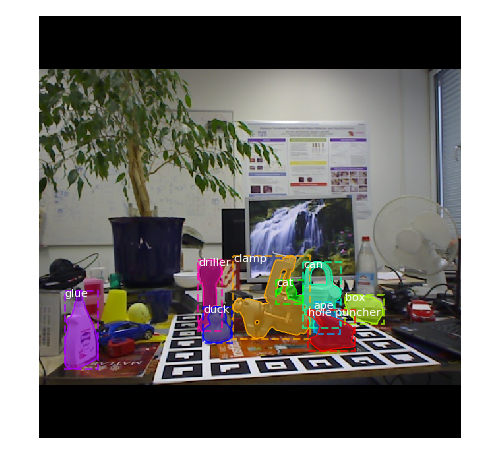

(640, 640, 8)
81
{'id': 499, 'path': '../datasets/sixd/hinterstoisser/test/02/rgb/0499.png', 'source': 'hinterstoisser'}


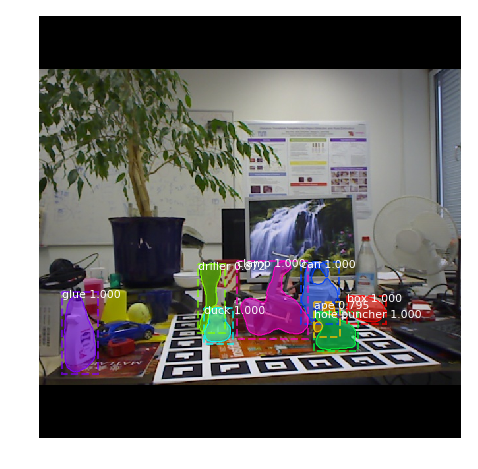

In [4]:
# Test on a random image
dataset = dataset_test
image_id = 81#random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
results = model.detect([original_image], verbose=1)
r = results[0]

from PIL import Image
original_image = np.pad(Image.open(dataset.image_info[image_id]['path']), 
                        [(80, 80), (0, 0), (0, 0)], mode='constant', constant_values=0)

#from PIL import Image
#import numpy as np
#original_image = Image.open('/home/mjakobsen/workspace/3D-pose-est-aid/mask_rcnn/google-doodle-on-hole-punch_650x400_71510653790.jpg')
#original_image = np.array(original_image)
    
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=get_ax())
print(r['masks'].shape)
print(image_id)
print(dataset.image_info[image_id])

In [5]:
print(image_ids)

NameError: name 'image_ids' is not defined

In [3]:
dataset_test_d = HinterstoisserDatasetD()
dataset_test_d.load_hinterstoisser(dataset_dir, 2, 'test_set_v1')
dataset_test_d.prepare()

dataset_test_rgb = HinterstoisserDatasetRGB()
dataset_test_rgb.load_hinterstoisser(dataset_dir, 2, 'test_set_v1')
dataset_test_rgb.prepare()

dataset_test_rgbd = HinterstoisserDatasetRGBD()
dataset_test_rgbd.load_hinterstoisser(dataset_dir, 2, 'test_set_v1')
dataset_test_rgbd.prepare()

../datasets/sixd/hinterstoisser/test/02
../datasets/sixd/hinterstoisser/test_set_v1.yml
../datasets/sixd/hinterstoisser/test/02
../datasets/sixd/hinterstoisser/test_set_v1.yml
../datasets/sixd/hinterstoisser/test/02
../datasets/sixd/hinterstoisser/test_set_v1.yml


In [ ]:
image_ids = dataset_test_rgb.image_ids
with tf.device("/gpu:1"):
    model = modellib.MaskRCNN(mode="inference", config=inference_config, model_dir='logs')
model.load_weights('logs/hinterstoisser_rgb_on_coco_depth_on_hinterstoisser_20180509T2329/mask_rcnn_hinterstoisser_rgbd_0100.h5', by_name=True)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    if(r['masks'].shape[2] == 0):
        AP = 0
    else:
        AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    print("mAP epoch 100: ", np.mean(APs))

In [ ]:
image_ids = dataset_test.image_ids
APmeans = []
print("TEST")
for i in range(1, 101):
    model.load_weights('logs/hinterstoisser_rgb_on_coco_depth_on_hinterstoisser_20180509T2329/mask_rcnn_hinterstoisser_rgbd_' + str(i).zfill(4) + '.h5', by_name=True)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_test, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        if(r['masks'].shape[2] == 0):
            AP = 0
        else:
            AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_test_rgbd_coco_d_hinterstoisser', APmeans)

print("VAL")
image_ids = dataset_val.image_ids
APmeans_val = []
for i in range(1, 101):
    model.load_weights('logs/hinterstoisser_rgb_on_coco_depth_on_hinterstoisser_20180509T2329/mask_rcnn_hinterstoisser_rgbd_' + str(i).zfill(4) + '.h5', by_name=True)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_val, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        if(r['masks'].shape[2] == 0):
            AP = 0
        else:
            AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans_val.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_val_rgbd_coco_d_hinterstoisser', APmeans_val)

print("TRAIN")
image_ids = np.random.choice(dataset_train.image_ids, 200)
APmeans_train = []
for i in range(1, 101):
    model.load_weights('logs/hinterstoisser_rgb_on_coco_depth_on_hinterstoisser_20180509T2329/mask_rcnn_hinterstoisser_rgbd_' + str(i).zfill(4) + '.h5', by_name=True)
    APs = []
    for image_id in image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset_train, inference_config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        # Compute AP
        if(r['masks'].shape[2] == 0):
            AP = 0
        else:
            AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask, 
                             r["rois"], r["class_ids"], r["scores"], r['masks'])
        APs.append(AP)
    APmeans_train.append(np.mean(APs))
    print("Epoch ", i, " - mAP: ", np.mean(APs))
np.save('AP_train_rgbd_coco_d_hinterstoisser', APmeans_train)


In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
image_ids = dataset_val.image_ids
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    print(AP)
    APs.append(AP)

APs_sorted = np.argsort(APs)

In [ ]:
worst_ids = APs_sorted[:10]
best_ids = APs_sorted[-10:]
print(worst_ids)
print(best_ids)

for image_id in worst_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())
    print(image_id)
    print(APs[image_id])
for image_id in best_ids:
    original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config, 
                               image_id, use_mini_mask=False)
    results = model.detect([original_image], verbose=1)
    r = results[0]
    visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                                dataset_val.class_names, r['scores'], ax=get_ax())
    print(image_id)
    print(APs[image_id])

In [ ]:
def movingaverage (values, window):
    return np.convolve(values, np.repeat(1.0, window)/window, 'valid')

epochs = range(1, 101)
#APtrain = np.load('APs/AP_train_hinterstoisser.npy')
#APval = np.load('APs/AP_val_hinterstoisser.npy')
#APtest = np.load('APs/AP_test_hinterstoisser.npy')
APtrain = np.load('APs/AP_train_rgbd_bottom_up.npy')
APval = np.load('APs/AP_val_rgbd_bottom_up.npy')
APtest = np.load('APs/AP_test_rgbd_bottom_up.npy')

APtestMA = movingaverage(APtest, 3)
APvalMA = movingaverage(APval, 3)
APtrainMA = movingaverage(APtrain, 3)
#APtestMA2 = movingaverage(APtest2, 3)
#APvalMA2 = movingaverage(APval2, 3)
#APtrainMA2 = movingaverage(APtrain2, 3)

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.plot(epochs[len(epochs)-len(APtrainMA):], APtrainMA, 'b-')
plt.plot(epochs[len(epochs)-len(APvalMA):], APvalMA, 'r-')
plt.plot(epochs[len(epochs)-len(APtestMA):], APtestMA, 'g-')

#plt.plot(epochs[len(epochs)-len(APtrainMA2):], APtrainMA2, 'b--')
#plt.plot(epochs[len(epochs)-len(APvalMA2):], APvalMA2, 'r--')
#plt.plot(epochs[len(epochs)-len(APtestMA2):], APtestMA2, 'g--')
#plt.plot(epochs, APtrain, 'bo', markersize=2)
#plt.plot(epochs, APval, 'ro', markersize=2)
#plt.plot(epochs, APtest, 'go', markersize=2)
#plt.plot(epochs, APtestcup, 'co', markersize=2)
#plt.plot(epochs, APtestcup, 'mo', markersize=2)
plt.legend(('train','val','test'), loc='right', bbox_to_anchor=(1, 0.65))
plt.savefig("graph.svg")
plt.show()

In [ ]:
dataset = dataset_test
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
#print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]

b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Generate Anchors
backbone_shapes = modellib.compute_backbone_shapes(config, config.IMAGE_SHAPE)
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          backbone_shapes,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image[:,:,:3], boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)
visualize.draw_boxes(sample_image[:,:,:3], boxes=anchors[neutral_anchor_ids])

In [ ]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

In [ ]:
import numpy as np
from pathlib import Path
import cv2
import shutil
out_dir = Path('../datasets/sixd/doumanoglou/test')
rgb_paths = out_dir.glob('**/rgb/*.png')
nparray = []
for p in rgb_paths:
    nparray.append(str(p))
np.random.shuffle(nparray)

val_length = len(nparray)//2

val_paths = nparray[:val_length]
test_paths = nparray[val_length:]

for val_paths in range(val_paths)
shutil.move(val_path, './out/mask/' + str(i) + '.png')

img = cv2.imread(info['path'])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [5]:
from PIL import Image
from pathlib import Path
from scipy import misc
image_ids = dataset_test.image_ids

for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, inference_config,
                               image_id, use_mini_mask=False)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    print(r['masks'][:,:].shape)
    print(r['class_ids'])
    if(r['masks'].shape[2] == 0): #no instances found
        print("ERROR - no instances found!")
        continue
    rgb_file = Path(dataset_test.image_info[image_id]['path'])
    print(rgb_file)
    with Image.open(rgb_file) as img:
        img_shape = img.size[1], img.size[0]
    padding = (max(img_shape) - min(img_shape)) // 2
    
    annotated_objects = [1, 2, 5, 6, 8, 9, 10, 11, 12]
    missing_ids = list(obj_id for obj_id in annotated_objects if obj_id not in r['class_ids'])
    found_ids = list(obj_id for obj_id in r['class_ids'] if obj_id in annotated_objects)
    missing_objects = len(missing_ids)
    found_objects = len(r['class_ids'])    
    
    img_mask = np.zeros((13, img_shape[0], img_shape[1]), dtype=np.uint8)
    for i in range(found_objects):   
        class_id = r['class_ids'][i]
        mask = r['masks'][padding:-padding, :, i]
        img_mask[class_id][mask] = class_id
        
    for obj in found_ids:
        outfile = Path('mask_results/{:02}'.format(obj)) / rgb_file.name
        print('\tSaving output file {} with 1 annotated instances...'.format(outfile))
        misc.imsave(str(outfile), img_mask[obj])
        
    if missing_objects > 0:
        print(missing_ids)
        img_mask_obj = np.zeros(img_shape, dtype=np.uint8)        
        for missing_id in missing_ids:
            outfile = Path('mask_results/{:02}'.format(missing_id)) / rgb_file.name
            misc.imsave(str(outfile), img_mask_obj)
            print('\tSaving output file {} with 0 annotated instances...'.format(outfile))

       

(640, 640, 8)
[ 9  6  2 10  5 12 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0003.png
	Saving output file mask_results/09/0003.png with 1 annotated instances...
	Saving output file mask_results/06/0003.png with 1 annotated instances...
	Saving output file mask_results/02/0003.png with 1 annotated instances...
	Saving output file mask_results/10/0003.png with 1 annotated instances...
	Saving output file mask_results/05/0003.png with 1 annotated instances...
	Saving output file mask_results/12/0003.png with 1 annotated instances...
	Saving output file mask_results/11/0003.png with 1 annotated instances...
	Saving output file mask_results/08/0003.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0003.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  2  6 10 12  5  8 11  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0008.png
	Saving output file mask_results/09/0008.png with 1 annotated instances...
	Saving output file mask_results/02/0008.png with 1 annotated instances...
	Saving output file mask_results/06/0008.png with 1 annotated instances...
	Saving output file mask_results/10/0008.png with 1 annotated instances...
	Saving output file mask_results/12/0008.png with 1 annotated instances...
	Saving output file mask_results/05/0008.png with 1 annotated instances...
	Saving output file mask_results/08/0008.png with 1 annotated instances...
	Saving output file mask_results/11/0008.png with 1 annotated instances...
	Saving output file mask_results/01/0008.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  5 10 12  2  6  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0017.png
	Saving output file mask_results/09/0017.png with 1 annotated instances...
	Saving output file mask_results/05/0017.png with 1 annotated instances...
	Saving output file mask_results/10/0017.png with 1 annotated instances...
	Saving output file mask_results/12/0017.png with 1 annotated instances...
	Saving output file mask_results/02/0017.png with 1 annotated instances...
	Saving output file mask_results/06/0017.png with 1 annotated instances...
	Saving output file mask_results/08/0017.png with 1 annotated instances...
	Saving output file mask_results/11/0017.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0017.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 12  2  5 10  8 11  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0027.png
	Saving output file mask_results/09/0027.png with 1 annotated instances...
	Saving output file mask_results/12/0027.png with 1 annotated instances...
	Saving output file mask_results/02/0027.png with 1 annotated instances...
	Saving output file mask_results/05/0027.png with 1 annotated instances...
	Saving output file mask_results/10/0027.png with 1 annotated instances...
	Saving output file mask_results/08/0027.png with 1 annotated instances...
	Saving output file mask_results/11/0027.png with 1 annotated instances...
	Saving output file mask_results/01/0027.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0027.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  2 12  8 10  6  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0036.png
	Saving output file mask_results/09/0036.png with 1 annotated instances...
	Saving output file mask_results/02/0036.png with 1 annotated instances...
	Saving output file mask_results/12/0036.png with 1 annotated instances...
	Saving output file mask_results/08/0036.png with 1 annotated instances...
	Saving output file mask_results/10/0036.png with 1 annotated instances...
	Saving output file mask_results/06/0036.png with 1 annotated instances...
	Saving output file mask_results/05/0036.png with 1 annotated instances...
	Saving output file mask_results/11/0036.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0036.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 12  2  6  8 10  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0038.png
	Saving output file mask_results/09/0038.png with 1 annotated instances...
	Saving output file mask_results/12/0038.png with 1 annotated instances...
	Saving output file mask_results/02/0038.png with 1 annotated instances...
	Saving output file mask_results/06/0038.png with 1 annotated instances...
	Saving output file mask_results/08/0038.png with 1 annotated instances...
	Saving output file mask_results/10/0038.png with 1 annotated instances...
	Saving output file mask_results/05/0038.png with 1 annotated instances...
	Saving output file mask_results/11/0038.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0038.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 5 10  9  8  6  2 12 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0039.png
	Saving output file mask_results/05/0039.png with 1 annotated instances...
	Saving output file mask_results/10/0039.png with 1 annotated instances...
	Saving output file mask_results/09/0039.png with 1 annotated instances...
	Saving output file mask_results/08/0039.png with 1 annotated instances...
	Saving output file mask_results/06/0039.png with 1 annotated instances...
	Saving output file mask_results/02/0039.png with 1 annotated instances...
	Saving output file mask_results/12/0039.png with 1 annotated instances...
	Saving output file mask_results/11/0039.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0039.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 5  9 12 10  6  8  2 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0041.png
	Saving output file mask_results/05/0041.png with 1 annotated instances...
	Saving output file mask_results/09/0041.png with 1 annotated instances...
	Saving output file mask_results/12/0041.png with 1 annotated instances...
	Saving output file mask_results/10/0041.png with 1 annotated instances...
	Saving output file mask_results/06/0041.png with 1 annotated instances...
	Saving output file mask_results/08/0041.png with 1 annotated instances...
	Saving output file mask_results/02/0041.png with 1 annotated instances...
	Saving output file mask_results/11/0041.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0041.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  5  9  6 12 11 10  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0047.png
	Saving output file mask_results/02/0047.png with 1 annotated instances...
	Saving output file mask_results/05/0047.png with 1 annotated instances...
	Saving output file mask_results/09/0047.png with 1 annotated instances...
	Saving output file mask_results/06/0047.png with 1 annotated instances...
	Saving output file mask_results/12/0047.png with 1 annotated instances...
	Saving output file mask_results/11/0047.png with 1 annotated instances...
	Saving output file mask_results/10/0047.png with 1 annotated instances...
	Saving output file mask_results/08/0047.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0047.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 5  9 12 10  2  8  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0058.png
	Saving output file mask_results/05/0058.png with 1 annotated instances...
	Saving output file mask_results/09/0058.png with 1 annotated instances...
	Saving output file mask_results/12/0058.png with 1 annotated instances...
	Saving output file mask_results/10/0058.png with 1 annotated instances...
	Saving output file mask_results/02/0058.png with 1 annotated instances...
	Saving output file mask_results/08/0058.png with 1 annotated instances...
	Saving output file mask_results/06/0058.png with 1 annotated instances...
	Saving output file mask_results/11/0058.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0058.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  9  5 12  6 10 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0061.png
	Saving output file mask_results/02/0061.png with 1 annotated instances...
	Saving output file mask_results/09/0061.png with 1 annotated instances...
	Saving output file mask_results/05/0061.png with 1 annotated instances...
	Saving output file mask_results/12/0061.png with 1 annotated instances...
	Saving output file mask_results/06/0061.png with 1 annotated instances...
	Saving output file mask_results/10/0061.png with 1 annotated instances...
	Saving output file mask_results/11/0061.png with 1 annotated instances...
	Saving output file mask_results/08/0061.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0061.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  5 12  2  6 10 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0062.png
	Saving output file mask_results/09/0062.png with 1 annotated instances...
	Saving output file mask_results/05/0062.png with 1 annotated instances...
	Saving output file mask_results/12/0062.png with 1 annotated instances...
	Saving output file mask_results/02/0062.png with 1 annotated instances...
	Saving output file mask_results/06/0062.png with 1 annotated instances...
	Saving output file mask_results/10/0062.png with 1 annotated instances...
	Saving output file mask_results/11/0062.png with 1 annotated instances...
	Saving output file mask_results/08/0062.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0062.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 2  9  5  6 12 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0064.png
	Saving output file mask_results/02/0064.png with 1 annotated instances...
	Saving output file mask_results/09/0064.png with 1 annotated instances...
	Saving output file mask_results/05/0064.png with 1 annotated instances...
	Saving output file mask_results/06/0064.png with 1 annotated instances...
	Saving output file mask_results/12/0064.png with 1 annotated instances...
	Saving output file mask_results/11/0064.png with 1 annotated instances...
	Saving output file mask_results/08/0064.png with 1 annotated instances...
[1, 10]
	Saving output file mask_results/01/0064.png with 0 annotated instances...
	Saving output file mask_results/10/0064.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  9  5 12  8 11 10  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0065.png
	Saving output file mask_results/02/0065.png with 1 annotated instances...
	Saving output file mask_results/09/0065.png with 1 annotated instances...
	Saving output file mask_results/05/0065.png with 1 annotated instances...
	Saving output file mask_results/12/0065.png with 1 annotated instances...
	Saving output file mask_results/08/0065.png with 1 annotated instances...
	Saving output file mask_results/11/0065.png with 1 annotated instances...
	Saving output file mask_results/10/0065.png with 1 annotated instances...
	Saving output file mask_results/06/0065.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0065.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  5  2  8 10 11  6 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0069.png
	Saving output file mask_results/09/0069.png with 1 annotated instances...
	Saving output file mask_results/05/0069.png with 1 annotated instances...
	Saving output file mask_results/02/0069.png with 1 annotated instances...
	Saving output file mask_results/08/0069.png with 1 annotated instances...
	Saving output file mask_results/10/0069.png with 1 annotated instances...
	Saving output file mask_results/11/0069.png with 1 annotated instances...
	Saving output file mask_results/06/0069.png with 1 annotated instances...
	Saving output file mask_results/12/0069.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0069.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 9  5 12  2 10 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0072.png
	Saving output file mask_results/09/0072.png with 1 annotated instances...
	Saving output file mask_results/05/0072.png with 1 annotated instances...
	Saving output file mask_results/12/0072.png with 1 annotated instances...
	Saving output file mask_results/02/0072.png with 1 annotated instances...
	Saving output file mask_results/10/0072.png with 1 annotated instances...
	Saving output file mask_results/11/0072.png with 1 annotated instances...
	Saving output file mask_results/08/0072.png with 1 annotated instances...
[1, 6]
	Saving output file mask_results/01/0072.png with 0 annotated instances...
	Saving output file mask_results/06/0072.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 6  5 10  1 12  2 11  9  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0079.png
	Saving output file mask_results/06/0079.png with 1 annotated instances...
	Saving output file mask_results/05/0079.png with 1 annotated instances...
	Saving output file mask_results/10/0079.png with 1 annotated instances...
	Saving output file mask_results/01/0079.png with 1 annotated instances...
	Saving output file mask_results/12/0079.png with 1 annotated instances...
	Saving output file mask_results/02/0079.png with 1 annotated instances...
	Saving output file mask_results/11/0079.png with 1 annotated instances...
	Saving output file mask_results/09/0079.png with 1 annotated instances...
	Saving output file mask_results/08/0079.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 6  5 10  1  2 12  9]
../datasets/sixd/hinterstoisser/test/02/rgb/0089.png
	Saving output file mask_results/06/0089.png with 1 annotated instances...
	Saving output file mask_results/05/0089.png with 1 annotated instances...
	Saving output file mask_results/10/0089.png with 1 annotated instances...
	Saving output file mask_results/01/0089.png with 1 annotated instances...
	Saving output file mask_results/02/0089.png with 1 annotated instances...
	Saving output file mask_results/12/0089.png with 1 annotated instances...
	Saving output file mask_results/09/0089.png with 1 annotated instances...
[8, 11]
	Saving output file mask_results/08/0089.png with 0 annotated instances...
	Saving output file mask_results/11/0089.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 1 10 12  2  6  5  9 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0096.png
	Saving output file mask_results/01/0096.png with 1 annotated instances...
	Saving output file mask_results/10/0096.png with 1 annotated instances...
	Saving output file mask_results/12/0096.png with 1 annotated instances...
	Saving output file mask_results/02/0096.png with 1 annotated instances...
	Saving output file mask_results/06/0096.png with 1 annotated instances...
	Saving output file mask_results/05/0096.png with 1 annotated instances...
	Saving output file mask_results/09/0096.png with 1 annotated instances...
	Saving output file mask_results/11/0096.png with 1 annotated instances...
[8]
	Saving output file mask_results/08/0096.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 1 12  2  5  6  9 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0097.png
	Saving output file mask_results/01/0097.png with 1 annotated instances...
	Saving output file mask_results/12/0097.png with 1 annotated instances...
	Saving output file mask_results/02/0097.png with 1 annotated instances...
	Saving output file mask_results/05/0097.png with 1 annotated instances...
	Saving output file mask_results/06/0097.png with 1 annotated instances...
	Saving output file mask_results/09/0097.png with 1 annotated instances...
	Saving output file mask_results/11/0097.png with 1 annotated instances...
	Saving output file mask_results/08/0097.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0097.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  1 10  2  5  6  9 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0102.png
	Saving output file mask_results/12/0102.png with 1 annotated instances...
	Saving output file mask_results/01/0102.png with 1 annotated instances...
	Saving output file mask_results/10/0102.png with 1 annotated instances...
	Saving output file mask_results/02/0102.png with 1 annotated instances...
	Saving output file mask_results/05/0102.png with 1 annotated instances...
	Saving output file mask_results/06/0102.png with 1 annotated instances...
	Saving output file mask_results/09/0102.png with 1 annotated instances...
	Saving output file mask_results/11/0102.png with 1 annotated instances...
	Saving output file mask_results/08/0102.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  9  6  5 10  2  8  1 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0107.png
	Saving output file mask_results/12/0107.png with 1 annotated instances...
	Saving output file mask_results/09/0107.png with 1 annotated instances...
	Saving output file mask_results/06/0107.png with 1 annotated instances...
	Saving output file mask_results/05/0107.png with 1 annotated instances...
	Saving output file mask_results/10/0107.png with 1 annotated instances...
	Saving output file mask_results/02/0107.png with 1 annotated instances...
	Saving output file mask_results/08/0107.png with 1 annotated instances...
	Saving output file mask_results/01/0107.png with 1 annotated instances...
	Saving output file mask_results/11/0107.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 6 12  5  2 10  1  9 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0110.png
	Saving output file mask_results/06/0110.png with 1 annotated instances...
	Saving output file mask_results/12/0110.png with 1 annotated instances...
	Saving output file mask_results/05/0110.png with 1 annotated instances...
	Saving output file mask_results/02/0110.png with 1 annotated instances...
	Saving output file mask_results/10/0110.png with 1 annotated instances...
	Saving output file mask_results/01/0110.png with 1 annotated instances...
	Saving output file mask_results/09/0110.png with 1 annotated instances...
	Saving output file mask_results/11/0110.png with 1 annotated instances...
	Saving output file mask_results/08/0110.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 2  6  5 10  1  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0115.png
	Saving output file mask_results/02/0115.png with 1 annotated instances...
	Saving output file mask_results/06/0115.png with 1 annotated instances...
	Saving output file mask_results/05/0115.png with 1 annotated instances...
	Saving output file mask_results/10/0115.png with 1 annotated instances...
	Saving output file mask_results/01/0115.png with 1 annotated instances...
	Saving output file mask_results/08/0115.png with 1 annotated instances...
	Saving output file mask_results/11/0115.png with 1 annotated instances...
[9, 12]
	Saving output file mask_results/09/0115.png with 0 annotated instances...
	Saving output file mask_results/12/0115.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 12  2  5  6 11  8  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0119.png
	Saving output file mask_results/09/0119.png with 1 annotated instances...
	Saving output file mask_results/12/0119.png with 1 annotated instances...
	Saving output file mask_results/02/0119.png with 1 annotated instances...
	Saving output file mask_results/05/0119.png with 1 annotated instances...
	Saving output file mask_results/06/0119.png with 1 annotated instances...
	Saving output file mask_results/11/0119.png with 1 annotated instances...
	Saving output file mask_results/08/0119.png with 1 annotated instances...
	Saving output file mask_results/01/0119.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0119.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  6  8 12 10  2  5  1 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0124.png
	Saving output file mask_results/09/0124.png with 1 annotated instances...
	Saving output file mask_results/06/0124.png with 1 annotated instances...
	Saving output file mask_results/08/0124.png with 1 annotated instances...
	Saving output file mask_results/12/0124.png with 1 annotated instances...
	Saving output file mask_results/10/0124.png with 1 annotated instances...
	Saving output file mask_results/02/0124.png with 1 annotated instances...
	Saving output file mask_results/05/0124.png with 1 annotated instances...
	Saving output file mask_results/01/0124.png with 1 annotated instances...
	Saving output file mask_results/11/0124.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  2 10  6 12  5  8  1 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0126.png
	Saving output file mask_results/09/0126.png with 1 annotated instances...
	Saving output file mask_results/02/0126.png with 1 annotated instances...
	Saving output file mask_results/10/0126.png with 1 annotated instances...
	Saving output file mask_results/06/0126.png with 1 annotated instances...
	Saving output file mask_results/12/0126.png with 1 annotated instances...
	Saving output file mask_results/05/0126.png with 1 annotated instances...
	Saving output file mask_results/08/0126.png with 1 annotated instances...
	Saving output file mask_results/01/0126.png with 1 annotated instances...
	Saving output file mask_results/11/0126.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 12  5  2 10  1 11  8  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0136.png
	Saving output file mask_results/09/0136.png with 1 annotated instances...
	Saving output file mask_results/12/0136.png with 1 annotated instances...
	Saving output file mask_results/05/0136.png with 1 annotated instances...
	Saving output file mask_results/02/0136.png with 1 annotated instances...
	Saving output file mask_results/10/0136.png with 1 annotated instances...
	Saving output file mask_results/01/0136.png with 1 annotated instances...
	Saving output file mask_results/11/0136.png with 1 annotated instances...
	Saving output file mask_results/08/0136.png with 1 annotated instances...
	Saving output file mask_results/06/0136.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 1  2  5 12  6 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0153.png
	Saving output file mask_results/01/0153.png with 1 annotated instances...
	Saving output file mask_results/02/0153.png with 1 annotated instances...
	Saving output file mask_results/05/0153.png with 1 annotated instances...
	Saving output file mask_results/12/0153.png with 1 annotated instances...
	Saving output file mask_results/06/0153.png with 1 annotated instances...
	Saving output file mask_results/11/0153.png with 1 annotated instances...
	Saving output file mask_results/08/0153.png with 1 annotated instances...
[9, 10]
	Saving output file mask_results/09/0153.png with 0 annotated instances...
	Saving output file mask_results/10/0153.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 1 10  2  6  5 12 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0156.png
	Saving output file mask_results/01/0156.png with 1 annotated instances...
	Saving output file mask_results/10/0156.png with 1 annotated instances...
	Saving output file mask_results/02/0156.png with 1 annotated instances...
	Saving output file mask_results/06/0156.png with 1 annotated instances...
	Saving output file mask_results/05/0156.png with 1 annotated instances...
	Saving output file mask_results/12/0156.png with 1 annotated instances...
	Saving output file mask_results/11/0156.png with 1 annotated instances...
	Saving output file mask_results/08/0156.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0156.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  6 10  5  9  2  8  1 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0162.png
	Saving output file mask_results/12/0162.png with 1 annotated instances...
	Saving output file mask_results/06/0162.png with 1 annotated instances...
	Saving output file mask_results/10/0162.png with 1 annotated instances...
	Saving output file mask_results/05/0162.png with 1 annotated instances...
	Saving output file mask_results/09/0162.png with 1 annotated instances...
	Saving output file mask_results/02/0162.png with 1 annotated instances...
	Saving output file mask_results/08/0162.png with 1 annotated instances...
	Saving output file mask_results/01/0162.png with 1 annotated instances...
	Saving output file mask_results/11/0162.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  2  9  8  1  5  6 11 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0166.png
	Saving output file mask_results/12/0166.png with 1 annotated instances...
	Saving output file mask_results/02/0166.png with 1 annotated instances...
	Saving output file mask_results/09/0166.png with 1 annotated instances...
	Saving output file mask_results/08/0166.png with 1 annotated instances...
	Saving output file mask_results/01/0166.png with 1 annotated instances...
	Saving output file mask_results/05/0166.png with 1 annotated instances...
	Saving output file mask_results/06/0166.png with 1 annotated instances...
	Saving output file mask_results/11/0166.png with 1 annotated instances...
	Saving output file mask_results/10/0166.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 12 10  5  1  8  2  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0175.png
	Saving output file mask_results/09/0175.png with 1 annotated instances...
	Saving output file mask_results/12/0175.png with 1 annotated instances...
	Saving output file mask_results/10/0175.png with 1 annotated instances...
	Saving output file mask_results/05/0175.png with 1 annotated instances...
	Saving output file mask_results/01/0175.png with 1 annotated instances...
	Saving output file mask_results/08/0175.png with 1 annotated instances...
	Saving output file mask_results/02/0175.png with 1 annotated instances...
	Saving output file mask_results/06/0175.png with 1 annotated instances...
	Saving output file mask_results/11/0175.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  9 10  5  8  2  6  1 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0176.png
	Saving output file mask_results/12/0176.png with 1 annotated instances...
	Saving output file mask_results/09/0176.png with 1 annotated instances...
	Saving output file mask_results/10/0176.png with 1 annotated instances...
	Saving output file mask_results/05/0176.png with 1 annotated instances...
	Saving output file mask_results/08/0176.png with 1 annotated instances...
	Saving output file mask_results/02/0176.png with 1 annotated instances...
	Saving output file mask_results/06/0176.png with 1 annotated instances...
	Saving output file mask_results/01/0176.png with 1 annotated instances...
	Saving output file mask_results/11/0176.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  2 12  1  8 11  5 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0178.png
	Saving output file mask_results/09/0178.png with 1 annotated instances...
	Saving output file mask_results/02/0178.png with 1 annotated instances...
	Saving output file mask_results/12/0178.png with 1 annotated instances...
	Saving output file mask_results/01/0178.png with 1 annotated instances...
	Saving output file mask_results/08/0178.png with 1 annotated instances...
	Saving output file mask_results/11/0178.png with 1 annotated instances...
	Saving output file mask_results/05/0178.png with 1 annotated instances...
	Saving output file mask_results/10/0178.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0178.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  9  6  1  8  2  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0203.png
	Saving output file mask_results/12/0203.png with 1 annotated instances...
	Saving output file mask_results/09/0203.png with 1 annotated instances...
	Saving output file mask_results/06/0203.png with 1 annotated instances...
	Saving output file mask_results/01/0203.png with 1 annotated instances...
	Saving output file mask_results/08/0203.png with 1 annotated instances...
	Saving output file mask_results/02/0203.png with 1 annotated instances...
	Saving output file mask_results/05/0203.png with 1 annotated instances...
	Saving output file mask_results/11/0203.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0203.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 2  1  6 12  8 11  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0207.png
	Saving output file mask_results/02/0207.png with 1 annotated instances...
	Saving output file mask_results/01/0207.png with 1 annotated instances...
	Saving output file mask_results/06/0207.png with 1 annotated instances...
	Saving output file mask_results/12/0207.png with 1 annotated instances...
	Saving output file mask_results/08/0207.png with 1 annotated instances...
	Saving output file mask_results/11/0207.png with 1 annotated instances...
	Saving output file mask_results/05/0207.png with 1 annotated instances...
[9, 10]
	Saving output file mask_results/09/0207.png with 0 annotated instances...
	Saving output file mask_results/10/0207.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 5 10  2 12  1  9  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0217.png
	Saving output file mask_results/05/0217.png with 1 annotated instances...
	Saving output file mask_results/10/0217.png with 1 annotated instances...
	Saving output file mask_results/02/0217.png with 1 annotated instances...
	Saving output file mask_results/12/0217.png with 1 annotated instances...
	Saving output file mask_results/01/0217.png with 1 annotated instances...
	Saving output file mask_results/09/0217.png with 1 annotated instances...
	Saving output file mask_results/08/0217.png with 1 annotated instances...
	Saving output file mask_results/11/0217.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0217.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  2  1 12  5  9  8 11  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0219.png
	Saving output file mask_results/10/0219.png with 1 annotated instances...
	Saving output file mask_results/02/0219.png with 1 annotated instances...
	Saving output file mask_results/01/0219.png with 1 annotated instances...
	Saving output file mask_results/12/0219.png with 1 annotated instances...
	Saving output file mask_results/05/0219.png with 1 annotated instances...
	Saving output file mask_results/09/0219.png with 1 annotated instances...
	Saving output file mask_results/08/0219.png with 1 annotated instances...
	Saving output file mask_results/11/0219.png with 1 annotated instances...
	Saving output file mask_results/06/0219.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2 10  6  1  5  8 12 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0221.png
	Saving output file mask_results/02/0221.png with 1 annotated instances...
	Saving output file mask_results/10/0221.png with 1 annotated instances...
	Saving output file mask_results/06/0221.png with 1 annotated instances...
	Saving output file mask_results/01/0221.png with 1 annotated instances...
	Saving output file mask_results/05/0221.png with 1 annotated instances...
	Saving output file mask_results/08/0221.png with 1 annotated instances...
	Saving output file mask_results/12/0221.png with 1 annotated instances...
	Saving output file mask_results/11/0221.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0221.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  2  9  1 10  5  6  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0224.png
	Saving output file mask_results/12/0224.png with 1 annotated instances...
	Saving output file mask_results/02/0224.png with 1 annotated instances...
	Saving output file mask_results/09/0224.png with 1 annotated instances...
	Saving output file mask_results/01/0224.png with 1 annotated instances...
	Saving output file mask_results/10/0224.png with 1 annotated instances...
	Saving output file mask_results/05/0224.png with 1 annotated instances...
	Saving output file mask_results/06/0224.png with 1 annotated instances...
	Saving output file mask_results/08/0224.png with 1 annotated instances...
	Saving output file mask_results/11/0224.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  2  1  6 11  5  8 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0243.png
	Saving output file mask_results/12/0243.png with 1 annotated instances...
	Saving output file mask_results/02/0243.png with 1 annotated instances...
	Saving output file mask_results/01/0243.png with 1 annotated instances...
	Saving output file mask_results/06/0243.png with 1 annotated instances...
	Saving output file mask_results/11/0243.png with 1 annotated instances...
	Saving output file mask_results/05/0243.png with 1 annotated instances...
	Saving output file mask_results/08/0243.png with 1 annotated instances...
	Saving output file mask_results/10/0243.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0243.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 1  2 12  5  8  6 11 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0248.png
	Saving output file mask_results/01/0248.png with 1 annotated instances...
	Saving output file mask_results/02/0248.png with 1 annotated instances...
	Saving output file mask_results/12/0248.png with 1 annotated instances...
	Saving output file mask_results/05/0248.png with 1 annotated instances...
	Saving output file mask_results/08/0248.png with 1 annotated instances...
	Saving output file mask_results/06/0248.png with 1 annotated instances...
	Saving output file mask_results/11/0248.png with 1 annotated instances...
	Saving output file mask_results/10/0248.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0248.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  8  1  6  5  2 10 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0249.png
	Saving output file mask_results/12/0249.png with 1 annotated instances...
	Saving output file mask_results/08/0249.png with 1 annotated instances...
	Saving output file mask_results/01/0249.png with 1 annotated instances...
	Saving output file mask_results/06/0249.png with 1 annotated instances...
	Saving output file mask_results/05/0249.png with 1 annotated instances...
	Saving output file mask_results/02/0249.png with 1 annotated instances...
	Saving output file mask_results/10/0249.png with 1 annotated instances...
	Saving output file mask_results/11/0249.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0249.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  2  1 11  8  6  9  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0254.png
	Saving output file mask_results/12/0254.png with 1 annotated instances...
	Saving output file mask_results/02/0254.png with 1 annotated instances...
	Saving output file mask_results/01/0254.png with 1 annotated instances...
	Saving output file mask_results/11/0254.png with 1 annotated instances...
	Saving output file mask_results/08/0254.png with 1 annotated instances...
	Saving output file mask_results/06/0254.png with 1 annotated instances...
	Saving output file mask_results/09/0254.png with 1 annotated instances...
	Saving output file mask_results/05/0254.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0254.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 6)
[ 6  2 12  5 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0258.png
	Saving output file mask_results/06/0258.png with 1 annotated instances...
	Saving output file mask_results/02/0258.png with 1 annotated instances...
	Saving output file mask_results/12/0258.png with 1 annotated instances...
	Saving output file mask_results/05/0258.png with 1 annotated instances...
	Saving output file mask_results/11/0258.png with 1 annotated instances...
	Saving output file mask_results/08/0258.png with 1 annotated instances...
[1, 9, 10]
	Saving output file mask_results/01/0258.png with 0 annotated instances...
	Saving output file mask_results/09/0258.png with 0 annotated instances...
	Saving output file mask_results/10/0258.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 2  6 12 10  5  1  8  9 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0263.png
	Saving output file mask_results/02/0263.png with 1 annotated instances...
	Saving output file mask_results/06/0263.png with 1 annotated instances...
	Saving output file mask_results/12/0263.png with 1 annotated instances...
	Saving output file mask_results/10/0263.png with 1 annotated instances...
	Saving output file mask_results/05/0263.png with 1 annotated instances...
	Saving output file mask_results/01/0263.png with 1 annotated instances...
	Saving output file mask_results/08/0263.png with 1 annotated instances...
	Saving output file mask_results/09/0263.png with 1 annotated instances...
	Saving output file mask_results/11/0263.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 10)
[12  2  5  6  8  1  9 10 11 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0266.png
	Saving output file mask_results/12/0266.png with 1 annotated instances...
	Saving output file mask_results/02/0266.png with 1 annotated instances...
	Saving output file mask_results/05/0266.png with 1 annotated instances...
	Saving output file mask_results/06/0266.png with 1 annotated instances...
	Saving output file mask_results/08/0266.png with 1 annotated instances...
	Saving output file mask_results/01/0266.png with 1 annotated instances...
	Saving output file mask_results/09/0266.png with 1 annotated instances...
	Saving output file mask_results/10/0266.png with 1 annotated instances...
	Saving output file mask_results/11/0266.png with 1 annotated instances...
	Saving output file mask_results/11/0266.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12 10  9  2  5  8  1  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0268.png
	Saving output file mask_results/12/0268.png with 1 annotated instances...
	Saving output file mask_results/10/0268.png with 1 annotated instances...
	Saving output file mask_results/09/0268.png with 1 annotated instances...
	Saving output file mask_results/02/0268.png with 1 annotated instances...
	Saving output file mask_results/05/0268.png with 1 annotated instances...
	Saving output file mask_results/08/0268.png with 1 annotated instances...
	Saving output file mask_results/01/0268.png with 1 annotated instances...
	Saving output file mask_results/06/0268.png with 1 annotated instances...
	Saving output file mask_results/11/0268.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  5 10  2  1  8 11  9  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0277.png
	Saving output file mask_results/12/0277.png with 1 annotated instances...
	Saving output file mask_results/05/0277.png with 1 annotated instances...
	Saving output file mask_results/10/0277.png with 1 annotated instances...
	Saving output file mask_results/02/0277.png with 1 annotated instances...
	Saving output file mask_results/01/0277.png with 1 annotated instances...
	Saving output file mask_results/08/0277.png with 1 annotated instances...
	Saving output file mask_results/11/0277.png with 1 annotated instances...
	Saving output file mask_results/09/0277.png with 1 annotated instances...
	Saving output file mask_results/06/0277.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 2 12  1 10  5  8  9]
../datasets/sixd/hinterstoisser/test/02/rgb/0283.png
	Saving output file mask_results/02/0283.png with 1 annotated instances...
	Saving output file mask_results/12/0283.png with 1 annotated instances...
	Saving output file mask_results/01/0283.png with 1 annotated instances...
	Saving output file mask_results/10/0283.png with 1 annotated instances...
	Saving output file mask_results/05/0283.png with 1 annotated instances...
	Saving output file mask_results/08/0283.png with 1 annotated instances...
	Saving output file mask_results/09/0283.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/0283.png with 0 annotated instances...
	Saving output file mask_results/11/0283.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  1  2  9  8  5 10  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0307.png
	Saving output file mask_results/12/0307.png with 1 annotated instances...
	Saving output file mask_results/01/0307.png with 1 annotated instances...
	Saving output file mask_results/02/0307.png with 1 annotated instances...
	Saving output file mask_results/09/0307.png with 1 annotated instances...
	Saving output file mask_results/08/0307.png with 1 annotated instances...
	Saving output file mask_results/05/0307.png with 1 annotated instances...
	Saving output file mask_results/10/0307.png with 1 annotated instances...
	Saving output file mask_results/06/0307.png with 1 annotated instances...
	Saving output file mask_results/11/0307.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2 12  1  8  9  5  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0310.png
	Saving output file mask_results/02/0310.png with 1 annotated instances...
	Saving output file mask_results/12/0310.png with 1 annotated instances...
	Saving output file mask_results/01/0310.png with 1 annotated instances...
	Saving output file mask_results/08/0310.png with 1 annotated instances...
	Saving output file mask_results/09/0310.png with 1 annotated instances...
	Saving output file mask_results/05/0310.png with 1 annotated instances...
	Saving output file mask_results/06/0310.png with 1 annotated instances...
	Saving output file mask_results/11/0310.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0310.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  5  1 12  6  8 11 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0322.png
	Saving output file mask_results/02/0322.png with 1 annotated instances...
	Saving output file mask_results/05/0322.png with 1 annotated instances...
	Saving output file mask_results/01/0322.png with 1 annotated instances...
	Saving output file mask_results/12/0322.png with 1 annotated instances...
	Saving output file mask_results/06/0322.png with 1 annotated instances...
	Saving output file mask_results/08/0322.png with 1 annotated instances...
	Saving output file mask_results/11/0322.png with 1 annotated instances...
	Saving output file mask_results/10/0322.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0322.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 2  1  5 12  8 11 10  6 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0326.png
	Saving output file mask_results/02/0326.png with 1 annotated instances...
	Saving output file mask_results/01/0326.png with 1 annotated instances...
	Saving output file mask_results/05/0326.png with 1 annotated instances...
	Saving output file mask_results/12/0326.png with 1 annotated instances...
	Saving output file mask_results/08/0326.png with 1 annotated instances...
	Saving output file mask_results/11/0326.png with 1 annotated instances...
	Saving output file mask_results/10/0326.png with 1 annotated instances...
	Saving output file mask_results/06/0326.png with 1 annotated instances...
	Saving output file mask_results/10/0326.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0326.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 5 12 10  9  2  1  8 11  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0338.png
	Saving output file mask_results/05/0338.png with 1 annotated instances...
	Saving output file mask_results/12/0338.png with 1 annotated instances...
	Saving output file mask_results/10/0338.png with 1 annotated instances...
	Saving output file mask_results/09/0338.png with 1 annotated instances...
	Saving output file mask_results/02/0338.png with 1 annotated instances...
	Saving output file mask_results/01/0338.png with 1 annotated instances...
	Saving output file mask_results/08/0338.png with 1 annotated instances...
	Saving output file mask_results/11/0338.png with 1 annotated instances...
	Saving output file mask_results/06/0338.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 2  5  9 12 10  6  1 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0342.png
	Saving output file mask_results/02/0342.png with 1 annotated instances...
	Saving output file mask_results/05/0342.png with 1 annotated instances...
	Saving output file mask_results/09/0342.png with 1 annotated instances...
	Saving output file mask_results/12/0342.png with 1 annotated instances...
	Saving output file mask_results/10/0342.png with 1 annotated instances...
	Saving output file mask_results/06/0342.png with 1 annotated instances...
	Saving output file mask_results/01/0342.png with 1 annotated instances...
	Saving output file mask_results/11/0342.png with 1 annotated instances...
	Saving output file mask_results/08/0342.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 10)
[ 2 12 10  1  6  9  5  8 11 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0356.png
	Saving output file mask_results/02/0356.png with 1 annotated instances...
	Saving output file mask_results/12/0356.png with 1 annotated instances...
	Saving output file mask_results/10/0356.png with 1 annotated instances...
	Saving output file mask_results/01/0356.png with 1 annotated instances...
	Saving output file mask_results/06/0356.png with 1 annotated instances...
	Saving output file mask_results/09/0356.png with 1 annotated instances...
	Saving output file mask_results/05/0356.png with 1 annotated instances...
	Saving output file mask_results/08/0356.png with 1 annotated instances...
	Saving output file mask_results/11/0356.png with 1 annotated instances...
	Saving output file mask_results/12/0356.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  2 10  1  9  5  8  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0362.png
	Saving output file mask_results/12/0362.png with 1 annotated instances...
	Saving output file mask_results/02/0362.png with 1 annotated instances...
	Saving output file mask_results/10/0362.png with 1 annotated instances...
	Saving output file mask_results/01/0362.png with 1 annotated instances...
	Saving output file mask_results/09/0362.png with 1 annotated instances...
	Saving output file mask_results/05/0362.png with 1 annotated instances...
	Saving output file mask_results/08/0362.png with 1 annotated instances...
	Saving output file mask_results/06/0362.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0362.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 12  6  2  1 10  5  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0365.png
	Saving output file mask_results/09/0365.png with 1 annotated instances...
	Saving output file mask_results/12/0365.png with 1 annotated instances...
	Saving output file mask_results/06/0365.png with 1 annotated instances...
	Saving output file mask_results/02/0365.png with 1 annotated instances...
	Saving output file mask_results/01/0365.png with 1 annotated instances...
	Saving output file mask_results/10/0365.png with 1 annotated instances...
	Saving output file mask_results/05/0365.png with 1 annotated instances...
	Saving output file mask_results/08/0365.png with 1 annotated instances...
	Saving output file mask_results/11/0365.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 12  1  8  2  5  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0368.png
	Saving output file mask_results/09/0368.png with 1 annotated instances...
	Saving output file mask_results/12/0368.png with 1 annotated instances...
	Saving output file mask_results/01/0368.png with 1 annotated instances...
	Saving output file mask_results/08/0368.png with 1 annotated instances...
	Saving output file mask_results/02/0368.png with 1 annotated instances...
	Saving output file mask_results/05/0368.png with 1 annotated instances...
	Saving output file mask_results/06/0368.png with 1 annotated instances...
	Saving output file mask_results/11/0368.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0368.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  6  9 10  5  8 11  2  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0387.png
	Saving output file mask_results/12/0387.png with 1 annotated instances...
	Saving output file mask_results/06/0387.png with 1 annotated instances...
	Saving output file mask_results/09/0387.png with 1 annotated instances...
	Saving output file mask_results/10/0387.png with 1 annotated instances...
	Saving output file mask_results/05/0387.png with 1 annotated instances...
	Saving output file mask_results/08/0387.png with 1 annotated instances...
	Saving output file mask_results/11/0387.png with 1 annotated instances...
	Saving output file mask_results/02/0387.png with 1 annotated instances...
	Saving output file mask_results/01/0387.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[12  2  8  6 11  9  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0389.png
	Saving output file mask_results/12/0389.png with 1 annotated instances...
	Saving output file mask_results/02/0389.png with 1 annotated instances...
	Saving output file mask_results/08/0389.png with 1 annotated instances...
	Saving output file mask_results/06/0389.png with 1 annotated instances...
	Saving output file mask_results/11/0389.png with 1 annotated instances...
	Saving output file mask_results/09/0389.png with 1 annotated instances...
	Saving output file mask_results/05/0389.png with 1 annotated instances...
[1, 10]
	Saving output file mask_results/01/0389.png with 0 annotated instances...
	Saving output file mask_results/10/0389.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 6  1  9 10 12  8  2  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0402.png
	Saving output file mask_results/06/0402.png with 1 annotated instances...
	Saving output file mask_results/01/0402.png with 1 annotated instances...
	Saving output file mask_results/09/0402.png with 1 annotated instances...
	Saving output file mask_results/10/0402.png with 1 annotated instances...
	Saving output file mask_results/12/0402.png with 1 annotated instances...
	Saving output file mask_results/08/0402.png with 1 annotated instances...
	Saving output file mask_results/02/0402.png with 1 annotated instances...
	Saving output file mask_results/05/0402.png with 1 annotated instances...
	Saving output file mask_results/11/0402.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 2  1  6  9 11  5 12  8 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0415.png
	Saving output file mask_results/02/0415.png with 1 annotated instances...
	Saving output file mask_results/01/0415.png with 1 annotated instances...
	Saving output file mask_results/06/0415.png with 1 annotated instances...
	Saving output file mask_results/09/0415.png with 1 annotated instances...
	Saving output file mask_results/11/0415.png with 1 annotated instances...
	Saving output file mask_results/05/0415.png with 1 annotated instances...
	Saving output file mask_results/12/0415.png with 1 annotated instances...
	Saving output file mask_results/08/0415.png with 1 annotated instances...
	Saving output file mask_results/10/0415.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  2  9  1  5  6  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0417.png
	Saving output file mask_results/12/0417.png with 1 annotated instances...
	Saving output file mask_results/02/0417.png with 1 annotated instances...
	Saving output file mask_results/09/0417.png with 1 annotated instances...
	Saving output file mask_results/01/0417.png with 1 annotated instances...
	Saving output file mask_results/05/0417.png with 1 annotated instances...
	Saving output file mask_results/06/0417.png with 1 annotated instances...
	Saving output file mask_results/08/0417.png with 1 annotated instances...
	Saving output file mask_results/11/0417.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0417.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  2  8 11 12  5 10  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0425.png
	Saving output file mask_results/09/0425.png with 1 annotated instances...
	Saving output file mask_results/02/0425.png with 1 annotated instances...
	Saving output file mask_results/08/0425.png with 1 annotated instances...
	Saving output file mask_results/11/0425.png with 1 annotated instances...
	Saving output file mask_results/12/0425.png with 1 annotated instances...
	Saving output file mask_results/05/0425.png with 1 annotated instances...
	Saving output file mask_results/10/0425.png with 1 annotated instances...
	Saving output file mask_results/01/0425.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0425.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 2  6  5 10  8  9  1 12 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0428.png
	Saving output file mask_results/02/0428.png with 1 annotated instances...
	Saving output file mask_results/06/0428.png with 1 annotated instances...
	Saving output file mask_results/05/0428.png with 1 annotated instances...
	Saving output file mask_results/10/0428.png with 1 annotated instances...
	Saving output file mask_results/08/0428.png with 1 annotated instances...
	Saving output file mask_results/09/0428.png with 1 annotated instances...
	Saving output file mask_results/01/0428.png with 1 annotated instances...
	Saving output file mask_results/12/0428.png with 1 annotated instances...
	Saving output file mask_results/11/0428.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  8  9  5 12  6 11  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0434.png
	Saving output file mask_results/02/0434.png with 1 annotated instances...
	Saving output file mask_results/08/0434.png with 1 annotated instances...
	Saving output file mask_results/09/0434.png with 1 annotated instances...
	Saving output file mask_results/05/0434.png with 1 annotated instances...
	Saving output file mask_results/12/0434.png with 1 annotated instances...
	Saving output file mask_results/06/0434.png with 1 annotated instances...
	Saving output file mask_results/11/0434.png with 1 annotated instances...
	Saving output file mask_results/01/0434.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0434.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  8  5  6  9 12 11  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0435.png
	Saving output file mask_results/02/0435.png with 1 annotated instances...
	Saving output file mask_results/08/0435.png with 1 annotated instances...
	Saving output file mask_results/05/0435.png with 1 annotated instances...
	Saving output file mask_results/06/0435.png with 1 annotated instances...
	Saving output file mask_results/09/0435.png with 1 annotated instances...
	Saving output file mask_results/12/0435.png with 1 annotated instances...
	Saving output file mask_results/11/0435.png with 1 annotated instances...
	Saving output file mask_results/01/0435.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0435.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  2  6  9  8 11 12  1  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0438.png
	Saving output file mask_results/10/0438.png with 1 annotated instances...
	Saving output file mask_results/02/0438.png with 1 annotated instances...
	Saving output file mask_results/06/0438.png with 1 annotated instances...
	Saving output file mask_results/09/0438.png with 1 annotated instances...
	Saving output file mask_results/08/0438.png with 1 annotated instances...
	Saving output file mask_results/11/0438.png with 1 annotated instances...
	Saving output file mask_results/12/0438.png with 1 annotated instances...
	Saving output file mask_results/01/0438.png with 1 annotated instances...
	Saving output file mask_results/05/0438.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  1 10  6  8 12  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0442.png
	Saving output file mask_results/02/0442.png with 1 annotated instances...
	Saving output file mask_results/01/0442.png with 1 annotated instances...
	Saving output file mask_results/10/0442.png with 1 annotated instances...
	Saving output file mask_results/06/0442.png with 1 annotated instances...
	Saving output file mask_results/08/0442.png with 1 annotated instances...
	Saving output file mask_results/12/0442.png with 1 annotated instances...
	Saving output file mask_results/05/0442.png with 1 annotated instances...
	Saving output file mask_results/11/0442.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0442.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 1 12  6  2 10  5  9  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0446.png
	Saving output file mask_results/01/0446.png with 1 annotated instances...
	Saving output file mask_results/12/0446.png with 1 annotated instances...
	Saving output file mask_results/06/0446.png with 1 annotated instances...
	Saving output file mask_results/02/0446.png with 1 annotated instances...
	Saving output file mask_results/10/0446.png with 1 annotated instances...
	Saving output file mask_results/05/0446.png with 1 annotated instances...
	Saving output file mask_results/09/0446.png with 1 annotated instances...
	Saving output file mask_results/08/0446.png with 1 annotated instances...
	Saving output file mask_results/11/0446.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12 10  1  6  2  8  5  9 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0453.png
	Saving output file mask_results/12/0453.png with 1 annotated instances...
	Saving output file mask_results/10/0453.png with 1 annotated instances...
	Saving output file mask_results/01/0453.png with 1 annotated instances...
	Saving output file mask_results/06/0453.png with 1 annotated instances...
	Saving output file mask_results/02/0453.png with 1 annotated instances...
	Saving output file mask_results/08/0453.png with 1 annotated instances...
	Saving output file mask_results/05/0453.png with 1 annotated instances...
	Saving output file mask_results/09/0453.png with 1 annotated instances...
	Saving output file mask_results/11/0453.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 10)
[ 9  1 12 10 11  2  5  8  6 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0473.png
	Saving output file mask_results/09/0473.png with 1 annotated instances...
	Saving output file mask_results/01/0473.png with 1 annotated instances...
	Saving output file mask_results/12/0473.png with 1 annotated instances...
	Saving output file mask_results/10/0473.png with 1 annotated instances...
	Saving output file mask_results/11/0473.png with 1 annotated instances...
	Saving output file mask_results/02/0473.png with 1 annotated instances...
	Saving output file mask_results/05/0473.png with 1 annotated instances...
	Saving output file mask_results/08/0473.png with 1 annotated instances...
	Saving output file mask_results/06/0473.png with 1 annotated instances...
	Saving output file mask_results/10/0473.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 1 12  5  6  2 11 10  9  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0474.png
	Saving output file mask_results/01/0474.png with 1 annotated instances...
	Saving output file mask_results/12/0474.png with 1 annotated instances...
	Saving output file mask_results/05/0474.png with 1 annotated instances...
	Saving output file mask_results/06/0474.png with 1 annotated instances...
	Saving output file mask_results/02/0474.png with 1 annotated instances...
	Saving output file mask_results/11/0474.png with 1 annotated instances...
	Saving output file mask_results/10/0474.png with 1 annotated instances...
	Saving output file mask_results/09/0474.png with 1 annotated instances...
	Saving output file mask_results/08/0474.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  6  1  2  8  9  5 10 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0476.png
	Saving output file mask_results/12/0476.png with 1 annotated instances...
	Saving output file mask_results/06/0476.png with 1 annotated instances...
	Saving output file mask_results/01/0476.png with 1 annotated instances...
	Saving output file mask_results/02/0476.png with 1 annotated instances...
	Saving output file mask_results/08/0476.png with 1 annotated instances...
	Saving output file mask_results/09/0476.png with 1 annotated instances...
	Saving output file mask_results/05/0476.png with 1 annotated instances...
	Saving output file mask_results/10/0476.png with 1 annotated instances...
	Saving output file mask_results/11/0476.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 10)
[ 6  2  8  1 12 10  9  5 11  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0477.png
	Saving output file mask_results/06/0477.png with 1 annotated instances...
	Saving output file mask_results/02/0477.png with 1 annotated instances...
	Saving output file mask_results/08/0477.png with 1 annotated instances...
	Saving output file mask_results/01/0477.png with 1 annotated instances...
	Saving output file mask_results/12/0477.png with 1 annotated instances...
	Saving output file mask_results/10/0477.png with 1 annotated instances...
	Saving output file mask_results/09/0477.png with 1 annotated instances...
	Saving output file mask_results/05/0477.png with 1 annotated instances...
	Saving output file mask_results/11/0477.png with 1 annotated instances...
	Saving output file mask_results/05/0477.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 6  8  1 12  2 11  9 10  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0480.png
	Saving output file mask_results/06/0480.png with 1 annotated instances...
	Saving output file mask_results/08/0480.png with 1 annotated instances...
	Saving output file mask_results/01/0480.png with 1 annotated instances...
	Saving output file mask_results/12/0480.png with 1 annotated instances...
	Saving output file mask_results/02/0480.png with 1 annotated instances...
	Saving output file mask_results/11/0480.png with 1 annotated instances...
	Saving output file mask_results/09/0480.png with 1 annotated instances...
	Saving output file mask_results/10/0480.png with 1 annotated instances...
	Saving output file mask_results/05/0480.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  1  6 10  8  5 11  2 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0491.png
	Saving output file mask_results/09/0491.png with 1 annotated instances...
	Saving output file mask_results/01/0491.png with 1 annotated instances...
	Saving output file mask_results/06/0491.png with 1 annotated instances...
	Saving output file mask_results/10/0491.png with 1 annotated instances...
	Saving output file mask_results/08/0491.png with 1 annotated instances...
	Saving output file mask_results/05/0491.png with 1 annotated instances...
	Saving output file mask_results/11/0491.png with 1 annotated instances...
	Saving output file mask_results/02/0491.png with 1 annotated instances...
	Saving output file mask_results/12/0491.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  2 12  5 10 11  8  1  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0494.png
	Saving output file mask_results/09/0494.png with 1 annotated instances...
	Saving output file mask_results/02/0494.png with 1 annotated instances...
	Saving output file mask_results/12/0494.png with 1 annotated instances...
	Saving output file mask_results/05/0494.png with 1 annotated instances...
	Saving output file mask_results/10/0494.png with 1 annotated instances...
	Saving output file mask_results/11/0494.png with 1 annotated instances...
	Saving output file mask_results/08/0494.png with 1 annotated instances...
	Saving output file mask_results/01/0494.png with 1 annotated instances...
	Saving output file mask_results/06/0494.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[11 12  9 10  5  2  8  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0499.png
	Saving output file mask_results/11/0499.png with 1 annotated instances...
	Saving output file mask_results/12/0499.png with 1 annotated instances...
	Saving output file mask_results/09/0499.png with 1 annotated instances...
	Saving output file mask_results/10/0499.png with 1 annotated instances...
	Saving output file mask_results/05/0499.png with 1 annotated instances...
	Saving output file mask_results/02/0499.png with 1 annotated instances...
	Saving output file mask_results/08/0499.png with 1 annotated instances...
	Saving output file mask_results/01/0499.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0499.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 2 12  9 10  5  8  1  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0501.png
	Saving output file mask_results/02/0501.png with 1 annotated instances...
	Saving output file mask_results/12/0501.png with 1 annotated instances...
	Saving output file mask_results/09/0501.png with 1 annotated instances...
	Saving output file mask_results/10/0501.png with 1 annotated instances...
	Saving output file mask_results/05/0501.png with 1 annotated instances...
	Saving output file mask_results/08/0501.png with 1 annotated instances...
	Saving output file mask_results/01/0501.png with 1 annotated instances...
	Saving output file mask_results/06/0501.png with 1 annotated instances...
	Saving output file mask_results/11/0501.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  6  2 12 11  8  5 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0503.png
	Saving output file mask_results/09/0503.png with 1 annotated instances...
	Saving output file mask_results/06/0503.png with 1 annotated instances...
	Saving output file mask_results/02/0503.png with 1 annotated instances...
	Saving output file mask_results/12/0503.png with 1 annotated instances...
	Saving output file mask_results/11/0503.png with 1 annotated instances...
	Saving output file mask_results/08/0503.png with 1 annotated instances...
	Saving output file mask_results/05/0503.png with 1 annotated instances...
	Saving output file mask_results/10/0503.png with 1 annotated instances...
[1]
	Saving output file mask_results/01/0503.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  2 11 10 12  1  5  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0521.png
	Saving output file mask_results/09/0521.png with 1 annotated instances...
	Saving output file mask_results/02/0521.png with 1 annotated instances...
	Saving output file mask_results/11/0521.png with 1 annotated instances...
	Saving output file mask_results/10/0521.png with 1 annotated instances...
	Saving output file mask_results/12/0521.png with 1 annotated instances...
	Saving output file mask_results/01/0521.png with 1 annotated instances...
	Saving output file mask_results/05/0521.png with 1 annotated instances...
	Saving output file mask_results/06/0521.png with 1 annotated instances...
	Saving output file mask_results/08/0521.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 8  2 12  1 11  5  6 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0527.png
	Saving output file mask_results/08/0527.png with 1 annotated instances...
	Saving output file mask_results/02/0527.png with 1 annotated instances...
	Saving output file mask_results/12/0527.png with 1 annotated instances...
	Saving output file mask_results/01/0527.png with 1 annotated instances...
	Saving output file mask_results/11/0527.png with 1 annotated instances...
	Saving output file mask_results/05/0527.png with 1 annotated instances...
	Saving output file mask_results/06/0527.png with 1 annotated instances...
	Saving output file mask_results/10/0527.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0527.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  6  8 12  1  5 11 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0529.png
	Saving output file mask_results/02/0529.png with 1 annotated instances...
	Saving output file mask_results/06/0529.png with 1 annotated instances...
	Saving output file mask_results/08/0529.png with 1 annotated instances...
	Saving output file mask_results/12/0529.png with 1 annotated instances...
	Saving output file mask_results/01/0529.png with 1 annotated instances...
	Saving output file mask_results/05/0529.png with 1 annotated instances...
	Saving output file mask_results/11/0529.png with 1 annotated instances...
	Saving output file mask_results/10/0529.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0529.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  2  9  8  1  5  6 11 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0532.png
	Saving output file mask_results/12/0532.png with 1 annotated instances...
	Saving output file mask_results/02/0532.png with 1 annotated instances...
	Saving output file mask_results/09/0532.png with 1 annotated instances...
	Saving output file mask_results/08/0532.png with 1 annotated instances...
	Saving output file mask_results/01/0532.png with 1 annotated instances...
	Saving output file mask_results/05/0532.png with 1 annotated instances...
	Saving output file mask_results/06/0532.png with 1 annotated instances...
	Saving output file mask_results/11/0532.png with 1 annotated instances...
	Saving output file mask_results/10/0532.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 12  5 10  2  8  6  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0535.png
	Saving output file mask_results/09/0535.png with 1 annotated instances...
	Saving output file mask_results/12/0535.png with 1 annotated instances...
	Saving output file mask_results/05/0535.png with 1 annotated instances...
	Saving output file mask_results/10/0535.png with 1 annotated instances...
	Saving output file mask_results/02/0535.png with 1 annotated instances...
	Saving output file mask_results/08/0535.png with 1 annotated instances...
	Saving output file mask_results/06/0535.png with 1 annotated instances...
	Saving output file mask_results/01/0535.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0535.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  9 12  1  6 10  5  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0540.png
	Saving output file mask_results/02/0540.png with 1 annotated instances...
	Saving output file mask_results/09/0540.png with 1 annotated instances...
	Saving output file mask_results/12/0540.png with 1 annotated instances...
	Saving output file mask_results/01/0540.png with 1 annotated instances...
	Saving output file mask_results/06/0540.png with 1 annotated instances...
	Saving output file mask_results/10/0540.png with 1 annotated instances...
	Saving output file mask_results/05/0540.png with 1 annotated instances...
	Saving output file mask_results/08/0540.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0540.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  2 11  6  8  1  5 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0543.png
	Saving output file mask_results/12/0543.png with 1 annotated instances...
	Saving output file mask_results/02/0543.png with 1 annotated instances...
	Saving output file mask_results/11/0543.png with 1 annotated instances...
	Saving output file mask_results/06/0543.png with 1 annotated instances...
	Saving output file mask_results/08/0543.png with 1 annotated instances...
	Saving output file mask_results/01/0543.png with 1 annotated instances...
	Saving output file mask_results/05/0543.png with 1 annotated instances...
	Saving output file mask_results/10/0543.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0543.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  5  1  2  6  8 10 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0549.png
	Saving output file mask_results/12/0549.png with 1 annotated instances...
	Saving output file mask_results/05/0549.png with 1 annotated instances...
	Saving output file mask_results/01/0549.png with 1 annotated instances...
	Saving output file mask_results/02/0549.png with 1 annotated instances...
	Saving output file mask_results/06/0549.png with 1 annotated instances...
	Saving output file mask_results/08/0549.png with 1 annotated instances...
	Saving output file mask_results/10/0549.png with 1 annotated instances...
	Saving output file mask_results/11/0549.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0549.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  9  1  2  5 10  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0560.png
	Saving output file mask_results/12/0560.png with 1 annotated instances...
	Saving output file mask_results/09/0560.png with 1 annotated instances...
	Saving output file mask_results/01/0560.png with 1 annotated instances...
	Saving output file mask_results/02/0560.png with 1 annotated instances...
	Saving output file mask_results/05/0560.png with 1 annotated instances...
	Saving output file mask_results/10/0560.png with 1 annotated instances...
	Saving output file mask_results/06/0560.png with 1 annotated instances...
	Saving output file mask_results/08/0560.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0560.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  9  2  5  1  6 10  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0563.png
	Saving output file mask_results/12/0563.png with 1 annotated instances...
	Saving output file mask_results/09/0563.png with 1 annotated instances...
	Saving output file mask_results/02/0563.png with 1 annotated instances...
	Saving output file mask_results/05/0563.png with 1 annotated instances...
	Saving output file mask_results/01/0563.png with 1 annotated instances...
	Saving output file mask_results/06/0563.png with 1 annotated instances...
	Saving output file mask_results/10/0563.png with 1 annotated instances...
	Saving output file mask_results/08/0563.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0563.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  1  2 10 12  5  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0571.png
	Saving output file mask_results/09/0571.png with 1 annotated instances...
	Saving output file mask_results/01/0571.png with 1 annotated instances...
	Saving output file mask_results/02/0571.png with 1 annotated instances...
	Saving output file mask_results/10/0571.png with 1 annotated instances...
	Saving output file mask_results/12/0571.png with 1 annotated instances...
	Saving output file mask_results/05/0571.png with 1 annotated instances...
	Saving output file mask_results/06/0571.png with 1 annotated instances...
	Saving output file mask_results/08/0571.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0571.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2 11 12  5  1 10  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0575.png
	Saving output file mask_results/02/0575.png with 1 annotated instances...
	Saving output file mask_results/11/0575.png with 1 annotated instances...
	Saving output file mask_results/12/0575.png with 1 annotated instances...
	Saving output file mask_results/05/0575.png with 1 annotated instances...
	Saving output file mask_results/01/0575.png with 1 annotated instances...
	Saving output file mask_results/10/0575.png with 1 annotated instances...
	Saving output file mask_results/06/0575.png with 1 annotated instances...
	Saving output file mask_results/08/0575.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0575.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  5  1  9  2  6 10  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0589.png
	Saving output file mask_results/12/0589.png with 1 annotated instances...
	Saving output file mask_results/05/0589.png with 1 annotated instances...
	Saving output file mask_results/01/0589.png with 1 annotated instances...
	Saving output file mask_results/09/0589.png with 1 annotated instances...
	Saving output file mask_results/02/0589.png with 1 annotated instances...
	Saving output file mask_results/06/0589.png with 1 annotated instances...
	Saving output file mask_results/10/0589.png with 1 annotated instances...
	Saving output file mask_results/08/0589.png with 1 annotated instances...
	Saving output file mask_results/11/0589.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 10)
[ 9  2  1  5 12  6 10 11  8  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0603.png
	Saving output file mask_results/09/0603.png with 1 annotated instances...
	Saving output file mask_results/02/0603.png with 1 annotated instances...
	Saving output file mask_results/01/0603.png with 1 annotated instances...
	Saving output file mask_results/05/0603.png with 1 annotated instances...
	Saving output file mask_results/12/0603.png with 1 annotated instances...
	Saving output file mask_results/06/0603.png with 1 annotated instances...
	Saving output file mask_results/10/0603.png with 1 annotated instances...
	Saving output file mask_results/11/0603.png with 1 annotated instances...
	Saving output file mask_results/08/0603.png with 1 annotated instances...
	Saving output file mask_results/05/0603.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  9  8 10  5  2  6  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0607.png
	Saving output file mask_results/12/0607.png with 1 annotated instances...
	Saving output file mask_results/09/0607.png with 1 annotated instances...
	Saving output file mask_results/08/0607.png with 1 annotated instances...
	Saving output file mask_results/10/0607.png with 1 annotated instances...
	Saving output file mask_results/05/0607.png with 1 annotated instances...
	Saving output file mask_results/02/0607.png with 1 annotated instances...
	Saving output file mask_results/06/0607.png with 1 annotated instances...
	Saving output file mask_results/01/0607.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0607.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[12  9  2 10  5  8  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0611.png
	Saving output file mask_results/12/0611.png with 1 annotated instances...
	Saving output file mask_results/09/0611.png with 1 annotated instances...
	Saving output file mask_results/02/0611.png with 1 annotated instances...
	Saving output file mask_results/10/0611.png with 1 annotated instances...
	Saving output file mask_results/05/0611.png with 1 annotated instances...
	Saving output file mask_results/08/0611.png with 1 annotated instances...
	Saving output file mask_results/01/0611.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/0611.png with 0 annotated instances...
	Saving output file mask_results/11/0611.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12 10  1  2  9  8  6  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0615.png
	Saving output file mask_results/12/0615.png with 1 annotated instances...
	Saving output file mask_results/10/0615.png with 1 annotated instances...
	Saving output file mask_results/01/0615.png with 1 annotated instances...
	Saving output file mask_results/02/0615.png with 1 annotated instances...
	Saving output file mask_results/09/0615.png with 1 annotated instances...
	Saving output file mask_results/08/0615.png with 1 annotated instances...
	Saving output file mask_results/06/0615.png with 1 annotated instances...
	Saving output file mask_results/05/0615.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0615.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 8  2  9  1 12 10  5 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0625.png
	Saving output file mask_results/08/0625.png with 1 annotated instances...
	Saving output file mask_results/02/0625.png with 1 annotated instances...
	Saving output file mask_results/09/0625.png with 1 annotated instances...
	Saving output file mask_results/01/0625.png with 1 annotated instances...
	Saving output file mask_results/12/0625.png with 1 annotated instances...
	Saving output file mask_results/10/0625.png with 1 annotated instances...
	Saving output file mask_results/05/0625.png with 1 annotated instances...
	Saving output file mask_results/10/0625.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/0625.png with 0 annotated instances...
	Saving output file mask_results/11/0625.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10 12  9  2  6  8  5  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0642.png
	Saving output file mask_results/10/0642.png with 1 annotated instances...
	Saving output file mask_results/12/0642.png with 1 annotated instances...
	Saving output file mask_results/09/0642.png with 1 annotated instances...
	Saving output file mask_results/02/0642.png with 1 annotated instances...
	Saving output file mask_results/06/0642.png with 1 annotated instances...
	Saving output file mask_results/08/0642.png with 1 annotated instances...
	Saving output file mask_results/05/0642.png with 1 annotated instances...
	Saving output file mask_results/01/0642.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0642.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 8  9 12  2 11  5  1 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0648.png
	Saving output file mask_results/08/0648.png with 1 annotated instances...
	Saving output file mask_results/09/0648.png with 1 annotated instances...
	Saving output file mask_results/12/0648.png with 1 annotated instances...
	Saving output file mask_results/02/0648.png with 1 annotated instances...
	Saving output file mask_results/11/0648.png with 1 annotated instances...
	Saving output file mask_results/05/0648.png with 1 annotated instances...
	Saving output file mask_results/01/0648.png with 1 annotated instances...
	Saving output file mask_results/10/0648.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0648.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2 12  8  6  9 10  1  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0649.png
	Saving output file mask_results/02/0649.png with 1 annotated instances...
	Saving output file mask_results/12/0649.png with 1 annotated instances...
	Saving output file mask_results/08/0649.png with 1 annotated instances...
	Saving output file mask_results/06/0649.png with 1 annotated instances...
	Saving output file mask_results/09/0649.png with 1 annotated instances...
	Saving output file mask_results/10/0649.png with 1 annotated instances...
	Saving output file mask_results/01/0649.png with 1 annotated instances...
	Saving output file mask_results/05/0649.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0649.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 8  9 12  2  1  8  5 11 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0650.png
	Saving output file mask_results/08/0650.png with 1 annotated instances...
	Saving output file mask_results/09/0650.png with 1 annotated instances...
	Saving output file mask_results/12/0650.png with 1 annotated instances...
	Saving output file mask_results/02/0650.png with 1 annotated instances...
	Saving output file mask_results/01/0650.png with 1 annotated instances...
	Saving output file mask_results/08/0650.png with 1 annotated instances...
	Saving output file mask_results/05/0650.png with 1 annotated instances...
	Saving output file mask_results/11/0650.png with 1 annotated instances...
	Saving output file mask_results/10/0650.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0650.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  2  5 10  1  9  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0652.png
	Saving output file mask_results/12/0652.png with 1 annotated instances...
	Saving output file mask_results/02/0652.png with 1 annotated instances...
	Saving output file mask_results/05/0652.png with 1 annotated instances...
	Saving output file mask_results/10/0652.png with 1 annotated instances...
	Saving output file mask_results/01/0652.png with 1 annotated instances...
	Saving output file mask_results/09/0652.png with 1 annotated instances...
	Saving output file mask_results/06/0652.png with 1 annotated instances...
	Saving output file mask_results/08/0652.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0652.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2 12  9  8  5  1  6 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0667.png
	Saving output file mask_results/02/0667.png with 1 annotated instances...
	Saving output file mask_results/12/0667.png with 1 annotated instances...
	Saving output file mask_results/09/0667.png with 1 annotated instances...
	Saving output file mask_results/08/0667.png with 1 annotated instances...
	Saving output file mask_results/05/0667.png with 1 annotated instances...
	Saving output file mask_results/01/0667.png with 1 annotated instances...
	Saving output file mask_results/06/0667.png with 1 annotated instances...
	Saving output file mask_results/10/0667.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0667.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2  9 12  1  5  6  8 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0669.png
	Saving output file mask_results/02/0669.png with 1 annotated instances...
	Saving output file mask_results/09/0669.png with 1 annotated instances...
	Saving output file mask_results/12/0669.png with 1 annotated instances...
	Saving output file mask_results/01/0669.png with 1 annotated instances...
	Saving output file mask_results/05/0669.png with 1 annotated instances...
	Saving output file mask_results/06/0669.png with 1 annotated instances...
	Saving output file mask_results/08/0669.png with 1 annotated instances...
	Saving output file mask_results/10/0669.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0669.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  8 12  6  2  1  9  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0679.png
	Saving output file mask_results/10/0679.png with 1 annotated instances...
	Saving output file mask_results/08/0679.png with 1 annotated instances...
	Saving output file mask_results/12/0679.png with 1 annotated instances...
	Saving output file mask_results/06/0679.png with 1 annotated instances...
	Saving output file mask_results/02/0679.png with 1 annotated instances...
	Saving output file mask_results/01/0679.png with 1 annotated instances...
	Saving output file mask_results/09/0679.png with 1 annotated instances...
	Saving output file mask_results/05/0679.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0679.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 5  9 12  1  2  8 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0691.png
	Saving output file mask_results/05/0691.png with 1 annotated instances...
	Saving output file mask_results/09/0691.png with 1 annotated instances...
	Saving output file mask_results/12/0691.png with 1 annotated instances...
	Saving output file mask_results/01/0691.png with 1 annotated instances...
	Saving output file mask_results/02/0691.png with 1 annotated instances...
	Saving output file mask_results/08/0691.png with 1 annotated instances...
	Saving output file mask_results/10/0691.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/0691.png with 0 annotated instances...
	Saving output file mask_results/11/0691.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[12 10  2  1  8  9  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0695.png
	Saving output file mask_results/12/0695.png with 1 annotated instances...
	Saving output file mask_results/10/0695.png with 1 annotated instances...
	Saving output file mask_results/02/0695.png with 1 annotated instances...
	Saving output file mask_results/01/0695.png with 1 annotated instances...
	Saving output file mask_results/08/0695.png with 1 annotated instances...
	Saving output file mask_results/09/0695.png with 1 annotated instances...
	Saving output file mask_results/05/0695.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/0695.png with 0 annotated instances...
	Saving output file mask_results/11/0695.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  8  1 10 11  2 12  5  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0703.png
	Saving output file mask_results/09/0703.png with 1 annotated instances...
	Saving output file mask_results/08/0703.png with 1 annotated instances...
	Saving output file mask_results/01/0703.png with 1 annotated instances...
	Saving output file mask_results/10/0703.png with 1 annotated instances...
	Saving output file mask_results/11/0703.png with 1 annotated instances...
	Saving output file mask_results/02/0703.png with 1 annotated instances...
	Saving output file mask_results/12/0703.png with 1 annotated instances...
	Saving output file mask_results/05/0703.png with 1 annotated instances...
	Saving output file mask_results/06/0703.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  6 12  9  8  5  2  1 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0708.png
	Saving output file mask_results/10/0708.png with 1 annotated instances...
	Saving output file mask_results/06/0708.png with 1 annotated instances...
	Saving output file mask_results/12/0708.png with 1 annotated instances...
	Saving output file mask_results/09/0708.png with 1 annotated instances...
	Saving output file mask_results/08/0708.png with 1 annotated instances...
	Saving output file mask_results/05/0708.png with 1 annotated instances...
	Saving output file mask_results/02/0708.png with 1 annotated instances...
	Saving output file mask_results/01/0708.png with 1 annotated instances...
	Saving output file mask_results/11/0708.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 10  8  6 11  1  2  5 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0711.png
	Saving output file mask_results/09/0711.png with 1 annotated instances...
	Saving output file mask_results/10/0711.png with 1 annotated instances...
	Saving output file mask_results/08/0711.png with 1 annotated instances...
	Saving output file mask_results/06/0711.png with 1 annotated instances...
	Saving output file mask_results/11/0711.png with 1 annotated instances...
	Saving output file mask_results/01/0711.png with 1 annotated instances...
	Saving output file mask_results/02/0711.png with 1 annotated instances...
	Saving output file mask_results/05/0711.png with 1 annotated instances...
	Saving output file mask_results/12/0711.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  1 11  5  6  8 12  2]
../datasets/sixd/hinterstoisser/test/02/rgb/0727.png
	Saving output file mask_results/10/0727.png with 1 annotated instances...
	Saving output file mask_results/01/0727.png with 1 annotated instances...
	Saving output file mask_results/11/0727.png with 1 annotated instances...
	Saving output file mask_results/05/0727.png with 1 annotated instances...
	Saving output file mask_results/06/0727.png with 1 annotated instances...
	Saving output file mask_results/08/0727.png with 1 annotated instances...
	Saving output file mask_results/12/0727.png with 1 annotated instances...
	Saving output file mask_results/02/0727.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0727.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 1  6  2  8 10 12  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0736.png
	Saving output file mask_results/01/0736.png with 1 annotated instances...
	Saving output file mask_results/06/0736.png with 1 annotated instances...
	Saving output file mask_results/02/0736.png with 1 annotated instances...
	Saving output file mask_results/08/0736.png with 1 annotated instances...
	Saving output file mask_results/10/0736.png with 1 annotated instances...
	Saving output file mask_results/12/0736.png with 1 annotated instances...
	Saving output file mask_results/05/0736.png with 1 annotated instances...
	Saving output file mask_results/11/0736.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0736.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 6  1 11  8 10  2  5 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0737.png
	Saving output file mask_results/06/0737.png with 1 annotated instances...
	Saving output file mask_results/01/0737.png with 1 annotated instances...
	Saving output file mask_results/11/0737.png with 1 annotated instances...
	Saving output file mask_results/08/0737.png with 1 annotated instances...
	Saving output file mask_results/10/0737.png with 1 annotated instances...
	Saving output file mask_results/02/0737.png with 1 annotated instances...
	Saving output file mask_results/05/0737.png with 1 annotated instances...
	Saving output file mask_results/12/0737.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0737.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  8  6  5  1  2 11 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0739.png
	Saving output file mask_results/10/0739.png with 1 annotated instances...
	Saving output file mask_results/08/0739.png with 1 annotated instances...
	Saving output file mask_results/06/0739.png with 1 annotated instances...
	Saving output file mask_results/05/0739.png with 1 annotated instances...
	Saving output file mask_results/01/0739.png with 1 annotated instances...
	Saving output file mask_results/02/0739.png with 1 annotated instances...
	Saving output file mask_results/11/0739.png with 1 annotated instances...
	Saving output file mask_results/12/0739.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/0739.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  6  9 11  1  8  2  5 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0740.png
	Saving output file mask_results/10/0740.png with 1 annotated instances...
	Saving output file mask_results/06/0740.png with 1 annotated instances...
	Saving output file mask_results/09/0740.png with 1 annotated instances...
	Saving output file mask_results/11/0740.png with 1 annotated instances...
	Saving output file mask_results/01/0740.png with 1 annotated instances...
	Saving output file mask_results/08/0740.png with 1 annotated instances...
	Saving output file mask_results/02/0740.png with 1 annotated instances...
	Saving output file mask_results/05/0740.png with 1 annotated instances...
	Saving output file mask_results/12/0740.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  9 12 11  1  2  8  5  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0750.png
	Saving output file mask_results/10/0750.png with 1 annotated instances...
	Saving output file mask_results/09/0750.png with 1 annotated instances...
	Saving output file mask_results/12/0750.png with 1 annotated instances...
	Saving output file mask_results/11/0750.png with 1 annotated instances...
	Saving output file mask_results/01/0750.png with 1 annotated instances...
	Saving output file mask_results/02/0750.png with 1 annotated instances...
	Saving output file mask_results/08/0750.png with 1 annotated instances...
	Saving output file mask_results/05/0750.png with 1 annotated instances...
	Saving output file mask_results/06/0750.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  9  6 12  8  2  1  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0754.png
	Saving output file mask_results/10/0754.png with 1 annotated instances...
	Saving output file mask_results/09/0754.png with 1 annotated instances...
	Saving output file mask_results/06/0754.png with 1 annotated instances...
	Saving output file mask_results/12/0754.png with 1 annotated instances...
	Saving output file mask_results/08/0754.png with 1 annotated instances...
	Saving output file mask_results/02/0754.png with 1 annotated instances...
	Saving output file mask_results/01/0754.png with 1 annotated instances...
	Saving output file mask_results/05/0754.png with 1 annotated instances...
	Saving output file mask_results/11/0754.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  9 11  1 12  2  8  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0756.png
	Saving output file mask_results/10/0756.png with 1 annotated instances...
	Saving output file mask_results/09/0756.png with 1 annotated instances...
	Saving output file mask_results/11/0756.png with 1 annotated instances...
	Saving output file mask_results/01/0756.png with 1 annotated instances...
	Saving output file mask_results/12/0756.png with 1 annotated instances...
	Saving output file mask_results/02/0756.png with 1 annotated instances...
	Saving output file mask_results/08/0756.png with 1 annotated instances...
	Saving output file mask_results/05/0756.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0756.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  9  1  2 11 12  5  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0757.png
	Saving output file mask_results/10/0757.png with 1 annotated instances...
	Saving output file mask_results/09/0757.png with 1 annotated instances...
	Saving output file mask_results/01/0757.png with 1 annotated instances...
	Saving output file mask_results/02/0757.png with 1 annotated instances...
	Saving output file mask_results/11/0757.png with 1 annotated instances...
	Saving output file mask_results/12/0757.png with 1 annotated instances...
	Saving output file mask_results/05/0757.png with 1 annotated instances...
	Saving output file mask_results/08/0757.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0757.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  9  2 12  1 11  5  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0758.png
	Saving output file mask_results/10/0758.png with 1 annotated instances...
	Saving output file mask_results/09/0758.png with 1 annotated instances...
	Saving output file mask_results/02/0758.png with 1 annotated instances...
	Saving output file mask_results/12/0758.png with 1 annotated instances...
	Saving output file mask_results/01/0758.png with 1 annotated instances...
	Saving output file mask_results/11/0758.png with 1 annotated instances...
	Saving output file mask_results/05/0758.png with 1 annotated instances...
	Saving output file mask_results/08/0758.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0758.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  9  5  1  2 12  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0761.png
	Saving output file mask_results/10/0761.png with 1 annotated instances...
	Saving output file mask_results/09/0761.png with 1 annotated instances...
	Saving output file mask_results/05/0761.png with 1 annotated instances...
	Saving output file mask_results/01/0761.png with 1 annotated instances...
	Saving output file mask_results/02/0761.png with 1 annotated instances...
	Saving output file mask_results/12/0761.png with 1 annotated instances...
	Saving output file mask_results/08/0761.png with 1 annotated instances...
	Saving output file mask_results/11/0761.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0761.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[10  9  2  8  1  5 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0762.png
	Saving output file mask_results/10/0762.png with 1 annotated instances...
	Saving output file mask_results/09/0762.png with 1 annotated instances...
	Saving output file mask_results/02/0762.png with 1 annotated instances...
	Saving output file mask_results/08/0762.png with 1 annotated instances...
	Saving output file mask_results/01/0762.png with 1 annotated instances...
	Saving output file mask_results/05/0762.png with 1 annotated instances...
	Saving output file mask_results/12/0762.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/0762.png with 0 annotated instances...
	Saving output file mask_results/11/0762.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  9 12  6  1  2  5  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0764.png
	Saving output file mask_results/10/0764.png with 1 annotated instances...
	Saving output file mask_results/09/0764.png with 1 annotated instances...
	Saving output file mask_results/12/0764.png with 1 annotated instances...
	Saving output file mask_results/06/0764.png with 1 annotated instances...
	Saving output file mask_results/01/0764.png with 1 annotated instances...
	Saving output file mask_results/02/0764.png with 1 annotated instances...
	Saving output file mask_results/05/0764.png with 1 annotated instances...
	Saving output file mask_results/08/0764.png with 1 annotated instances...
	Saving output file mask_results/11/0764.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  6 12  9  8  2  5 11  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0768.png
	Saving output file mask_results/10/0768.png with 1 annotated instances...
	Saving output file mask_results/06/0768.png with 1 annotated instances...
	Saving output file mask_results/12/0768.png with 1 annotated instances...
	Saving output file mask_results/09/0768.png with 1 annotated instances...
	Saving output file mask_results/08/0768.png with 1 annotated instances...
	Saving output file mask_results/02/0768.png with 1 annotated instances...
	Saving output file mask_results/05/0768.png with 1 annotated instances...
	Saving output file mask_results/11/0768.png with 1 annotated instances...
	Saving output file mask_results/01/0768.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10 12  6  9  8  2  1  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0769.png
	Saving output file mask_results/10/0769.png with 1 annotated instances...
	Saving output file mask_results/12/0769.png with 1 annotated instances...
	Saving output file mask_results/06/0769.png with 1 annotated instances...
	Saving output file mask_results/09/0769.png with 1 annotated instances...
	Saving output file mask_results/08/0769.png with 1 annotated instances...
	Saving output file mask_results/02/0769.png with 1 annotated instances...
	Saving output file mask_results/01/0769.png with 1 annotated instances...
	Saving output file mask_results/05/0769.png with 1 annotated instances...
	Saving output file mask_results/11/0769.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  9  2  6 10  8  5  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0770.png
	Saving output file mask_results/12/0770.png with 1 annotated instances...
	Saving output file mask_results/09/0770.png with 1 annotated instances...
	Saving output file mask_results/02/0770.png with 1 annotated instances...
	Saving output file mask_results/06/0770.png with 1 annotated instances...
	Saving output file mask_results/10/0770.png with 1 annotated instances...
	Saving output file mask_results/08/0770.png with 1 annotated instances...
	Saving output file mask_results/05/0770.png with 1 annotated instances...
	Saving output file mask_results/01/0770.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0770.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 10  6 12 11  2  8  5  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0773.png
	Saving output file mask_results/09/0773.png with 1 annotated instances...
	Saving output file mask_results/10/0773.png with 1 annotated instances...
	Saving output file mask_results/06/0773.png with 1 annotated instances...
	Saving output file mask_results/12/0773.png with 1 annotated instances...
	Saving output file mask_results/11/0773.png with 1 annotated instances...
	Saving output file mask_results/02/0773.png with 1 annotated instances...
	Saving output file mask_results/08/0773.png with 1 annotated instances...
	Saving output file mask_results/05/0773.png with 1 annotated instances...
	Saving output file mask_results/01/0773.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10 12  8  9  6  1  2  5 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0775.png
	Saving output file mask_results/10/0775.png with 1 annotated instances...
	Saving output file mask_results/12/0775.png with 1 annotated instances...
	Saving output file mask_results/08/0775.png with 1 annotated instances...
	Saving output file mask_results/09/0775.png with 1 annotated instances...
	Saving output file mask_results/06/0775.png with 1 annotated instances...
	Saving output file mask_results/01/0775.png with 1 annotated instances...
	Saving output file mask_results/02/0775.png with 1 annotated instances...
	Saving output file mask_results/05/0775.png with 1 annotated instances...
	Saving output file mask_results/11/0775.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 10)
[10  9  1 12  5  2  8 11  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0785.png
	Saving output file mask_results/10/0785.png with 1 annotated instances...
	Saving output file mask_results/09/0785.png with 1 annotated instances...
	Saving output file mask_results/01/0785.png with 1 annotated instances...
	Saving output file mask_results/12/0785.png with 1 annotated instances...
	Saving output file mask_results/05/0785.png with 1 annotated instances...
	Saving output file mask_results/02/0785.png with 1 annotated instances...
	Saving output file mask_results/08/0785.png with 1 annotated instances...
	Saving output file mask_results/11/0785.png with 1 annotated instances...
	Saving output file mask_results/06/0785.png with 1 annotated instances...
	Saving output file mask_results/11/0785.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[10  2  9  5 12  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0788.png
	Saving output file mask_results/10/0788.png with 1 annotated instances...
	Saving output file mask_results/02/0788.png with 1 annotated instances...
	Saving output file mask_results/09/0788.png with 1 annotated instances...
	Saving output file mask_results/05/0788.png with 1 annotated instances...
	Saving output file mask_results/12/0788.png with 1 annotated instances...
	Saving output file mask_results/08/0788.png with 1 annotated instances...
	Saving output file mask_results/11/0788.png with 1 annotated instances...
[1, 6]
	Saving output file mask_results/01/0788.png with 0 annotated instances...
	Saving output file mask_results/06/0788.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  9  2  1  5 12 11  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0791.png
	Saving output file mask_results/10/0791.png with 1 annotated instances...
	Saving output file mask_results/09/0791.png with 1 annotated instances...
	Saving output file mask_results/02/0791.png with 1 annotated instances...
	Saving output file mask_results/01/0791.png with 1 annotated instances...
	Saving output file mask_results/05/0791.png with 1 annotated instances...
	Saving output file mask_results/12/0791.png with 1 annotated instances...
	Saving output file mask_results/11/0791.png with 1 annotated instances...
	Saving output file mask_results/06/0791.png with 1 annotated instances...
	Saving output file mask_results/08/0791.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  9 12  5  2  1  8  6 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0794.png
	Saving output file mask_results/10/0794.png with 1 annotated instances...
	Saving output file mask_results/09/0794.png with 1 annotated instances...
	Saving output file mask_results/12/0794.png with 1 annotated instances...
	Saving output file mask_results/05/0794.png with 1 annotated instances...
	Saving output file mask_results/02/0794.png with 1 annotated instances...
	Saving output file mask_results/01/0794.png with 1 annotated instances...
	Saving output file mask_results/08/0794.png with 1 annotated instances...
	Saving output file mask_results/06/0794.png with 1 annotated instances...
	Saving output file mask_results/11/0794.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 10)
[ 9 10 12  2  5 11  6  8 10  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0801.png
	Saving output file mask_results/09/0801.png with 1 annotated instances...
	Saving output file mask_results/10/0801.png with 1 annotated instances...
	Saving output file mask_results/12/0801.png with 1 annotated instances...
	Saving output file mask_results/02/0801.png with 1 annotated instances...
	Saving output file mask_results/05/0801.png with 1 annotated instances...
	Saving output file mask_results/11/0801.png with 1 annotated instances...
	Saving output file mask_results/06/0801.png with 1 annotated instances...
	Saving output file mask_results/08/0801.png with 1 annotated instances...
	Saving output file mask_results/10/0801.png with 1 annotated instances...
	Saving output file mask_results/01/0801.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[10 12  9  2 11  5  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0803.png
	Saving output file mask_results/10/0803.png with 1 annotated instances...
	Saving output file mask_results/12/0803.png with 1 annotated instances...
	Saving output file mask_results/09/0803.png with 1 annotated instances...
	Saving output file mask_results/02/0803.png with 1 annotated instances...
	Saving output file mask_results/11/0803.png with 1 annotated instances...
	Saving output file mask_results/05/0803.png with 1 annotated instances...
	Saving output file mask_results/08/0803.png with 1 annotated instances...
[1, 6]
	Saving output file mask_results/01/0803.png with 0 annotated instances...
	Saving output file mask_results/06/0803.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[10 12  9  2 11  5  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0804.png
	Saving output file mask_results/10/0804.png with 1 annotated instances...
	Saving output file mask_results/12/0804.png with 1 annotated instances...
	Saving output file mask_results/09/0804.png with 1 annotated instances...
	Saving output file mask_results/02/0804.png with 1 annotated instances...
	Saving output file mask_results/11/0804.png with 1 annotated instances...
	Saving output file mask_results/05/0804.png with 1 annotated instances...
	Saving output file mask_results/08/0804.png with 1 annotated instances...
[1, 6]
	Saving output file mask_results/01/0804.png with 0 annotated instances...
	Saving output file mask_results/06/0804.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 10 11  2 12  5  6  1  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0808.png
	Saving output file mask_results/09/0808.png with 1 annotated instances...
	Saving output file mask_results/10/0808.png with 1 annotated instances...
	Saving output file mask_results/11/0808.png with 1 annotated instances...
	Saving output file mask_results/02/0808.png with 1 annotated instances...
	Saving output file mask_results/12/0808.png with 1 annotated instances...
	Saving output file mask_results/05/0808.png with 1 annotated instances...
	Saving output file mask_results/06/0808.png with 1 annotated instances...
	Saving output file mask_results/01/0808.png with 1 annotated instances...
	Saving output file mask_results/08/0808.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  5 10  6  8 12  2  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0809.png
	Saving output file mask_results/09/0809.png with 1 annotated instances...
	Saving output file mask_results/05/0809.png with 1 annotated instances...
	Saving output file mask_results/10/0809.png with 1 annotated instances...
	Saving output file mask_results/06/0809.png with 1 annotated instances...
	Saving output file mask_results/08/0809.png with 1 annotated instances...
	Saving output file mask_results/12/0809.png with 1 annotated instances...
	Saving output file mask_results/02/0809.png with 1 annotated instances...
	Saving output file mask_results/01/0809.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0809.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  6  9 10  2  8  5 11  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0819.png
	Saving output file mask_results/12/0819.png with 1 annotated instances...
	Saving output file mask_results/06/0819.png with 1 annotated instances...
	Saving output file mask_results/09/0819.png with 1 annotated instances...
	Saving output file mask_results/10/0819.png with 1 annotated instances...
	Saving output file mask_results/02/0819.png with 1 annotated instances...
	Saving output file mask_results/08/0819.png with 1 annotated instances...
	Saving output file mask_results/05/0819.png with 1 annotated instances...
	Saving output file mask_results/11/0819.png with 1 annotated instances...
	Saving output file mask_results/01/0819.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 10 12  8  6  2  5 11  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0821.png
	Saving output file mask_results/09/0821.png with 1 annotated instances...
	Saving output file mask_results/10/0821.png with 1 annotated instances...
	Saving output file mask_results/12/0821.png with 1 annotated instances...
	Saving output file mask_results/08/0821.png with 1 annotated instances...
	Saving output file mask_results/06/0821.png with 1 annotated instances...
	Saving output file mask_results/02/0821.png with 1 annotated instances...
	Saving output file mask_results/05/0821.png with 1 annotated instances...
	Saving output file mask_results/11/0821.png with 1 annotated instances...
	Saving output file mask_results/01/0821.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  8 10  5 12 11  1  2  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0828.png
	Saving output file mask_results/09/0828.png with 1 annotated instances...
	Saving output file mask_results/08/0828.png with 1 annotated instances...
	Saving output file mask_results/10/0828.png with 1 annotated instances...
	Saving output file mask_results/05/0828.png with 1 annotated instances...
	Saving output file mask_results/12/0828.png with 1 annotated instances...
	Saving output file mask_results/11/0828.png with 1 annotated instances...
	Saving output file mask_results/01/0828.png with 1 annotated instances...
	Saving output file mask_results/02/0828.png with 1 annotated instances...
	Saving output file mask_results/06/0828.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  9  2 12  6  8 11  5  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0837.png
	Saving output file mask_results/10/0837.png with 1 annotated instances...
	Saving output file mask_results/09/0837.png with 1 annotated instances...
	Saving output file mask_results/02/0837.png with 1 annotated instances...
	Saving output file mask_results/12/0837.png with 1 annotated instances...
	Saving output file mask_results/06/0837.png with 1 annotated instances...
	Saving output file mask_results/08/0837.png with 1 annotated instances...
	Saving output file mask_results/11/0837.png with 1 annotated instances...
	Saving output file mask_results/05/0837.png with 1 annotated instances...
	Saving output file mask_results/01/0837.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10 12  2  9 11  1  5  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0840.png
	Saving output file mask_results/10/0840.png with 1 annotated instances...
	Saving output file mask_results/12/0840.png with 1 annotated instances...
	Saving output file mask_results/02/0840.png with 1 annotated instances...
	Saving output file mask_results/09/0840.png with 1 annotated instances...
	Saving output file mask_results/11/0840.png with 1 annotated instances...
	Saving output file mask_results/01/0840.png with 1 annotated instances...
	Saving output file mask_results/05/0840.png with 1 annotated instances...
	Saving output file mask_results/08/0840.png with 1 annotated instances...
[6]
	Saving output file mask_results/06/0840.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  1  9 11  2  5 12  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0844.png
	Saving output file mask_results/10/0844.png with 1 annotated instances...
	Saving output file mask_results/01/0844.png with 1 annotated instances...
	Saving output file mask_results/09/0844.png with 1 annotated instances...
	Saving output file mask_results/11/0844.png with 1 annotated instances...
	Saving output file mask_results/02/0844.png with 1 annotated instances...
	Saving output file mask_results/05/0844.png with 1 annotated instances...
	Saving output file mask_results/12/0844.png with 1 annotated instances...
	Saving output file mask_results/06/0844.png with 1 annotated instances...
	Saving output file mask_results/08/0844.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[10  5  2  9  1  8 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0850.png
	Saving output file mask_results/10/0850.png with 1 annotated instances...
	Saving output file mask_results/05/0850.png with 1 annotated instances...
	Saving output file mask_results/02/0850.png with 1 annotated instances...
	Saving output file mask_results/09/0850.png with 1 annotated instances...
	Saving output file mask_results/01/0850.png with 1 annotated instances...
	Saving output file mask_results/08/0850.png with 1 annotated instances...
	Saving output file mask_results/12/0850.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/0850.png with 0 annotated instances...
	Saving output file mask_results/11/0850.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  9  8  2  5  1 11 12  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0856.png
	Saving output file mask_results/10/0856.png with 1 annotated instances...
	Saving output file mask_results/09/0856.png with 1 annotated instances...
	Saving output file mask_results/08/0856.png with 1 annotated instances...
	Saving output file mask_results/02/0856.png with 1 annotated instances...
	Saving output file mask_results/05/0856.png with 1 annotated instances...
	Saving output file mask_results/01/0856.png with 1 annotated instances...
	Saving output file mask_results/11/0856.png with 1 annotated instances...
	Saving output file mask_results/12/0856.png with 1 annotated instances...
	Saving output file mask_results/06/0856.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 12  1 10  8  2  6  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0867.png
	Saving output file mask_results/09/0867.png with 1 annotated instances...
	Saving output file mask_results/12/0867.png with 1 annotated instances...
	Saving output file mask_results/01/0867.png with 1 annotated instances...
	Saving output file mask_results/10/0867.png with 1 annotated instances...
	Saving output file mask_results/08/0867.png with 1 annotated instances...
	Saving output file mask_results/02/0867.png with 1 annotated instances...
	Saving output file mask_results/06/0867.png with 1 annotated instances...
	Saving output file mask_results/05/0867.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0867.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 10  1  8  2 12  5 11  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0871.png
	Saving output file mask_results/09/0871.png with 1 annotated instances...
	Saving output file mask_results/10/0871.png with 1 annotated instances...
	Saving output file mask_results/01/0871.png with 1 annotated instances...
	Saving output file mask_results/08/0871.png with 1 annotated instances...
	Saving output file mask_results/02/0871.png with 1 annotated instances...
	Saving output file mask_results/12/0871.png with 1 annotated instances...
	Saving output file mask_results/05/0871.png with 1 annotated instances...
	Saving output file mask_results/11/0871.png with 1 annotated instances...
	Saving output file mask_results/06/0871.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 10  8  1  6  2 12  5]
../datasets/sixd/hinterstoisser/test/02/rgb/0877.png
	Saving output file mask_results/09/0877.png with 1 annotated instances...
	Saving output file mask_results/10/0877.png with 1 annotated instances...
	Saving output file mask_results/08/0877.png with 1 annotated instances...
	Saving output file mask_results/01/0877.png with 1 annotated instances...
	Saving output file mask_results/06/0877.png with 1 annotated instances...
	Saving output file mask_results/02/0877.png with 1 annotated instances...
	Saving output file mask_results/12/0877.png with 1 annotated instances...
	Saving output file mask_results/05/0877.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0877.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  9  1  6  2  8  5 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0883.png
	Saving output file mask_results/10/0883.png with 1 annotated instances...
	Saving output file mask_results/09/0883.png with 1 annotated instances...
	Saving output file mask_results/01/0883.png with 1 annotated instances...
	Saving output file mask_results/06/0883.png with 1 annotated instances...
	Saving output file mask_results/02/0883.png with 1 annotated instances...
	Saving output file mask_results/08/0883.png with 1 annotated instances...
	Saving output file mask_results/05/0883.png with 1 annotated instances...
	Saving output file mask_results/12/0883.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0883.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  6  9  2  8  1  5 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0886.png
	Saving output file mask_results/10/0886.png with 1 annotated instances...
	Saving output file mask_results/06/0886.png with 1 annotated instances...
	Saving output file mask_results/09/0886.png with 1 annotated instances...
	Saving output file mask_results/02/0886.png with 1 annotated instances...
	Saving output file mask_results/08/0886.png with 1 annotated instances...
	Saving output file mask_results/01/0886.png with 1 annotated instances...
	Saving output file mask_results/05/0886.png with 1 annotated instances...
	Saving output file mask_results/12/0886.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0886.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 9  2 12 10  6  5  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0894.png
	Saving output file mask_results/09/0894.png with 1 annotated instances...
	Saving output file mask_results/02/0894.png with 1 annotated instances...
	Saving output file mask_results/12/0894.png with 1 annotated instances...
	Saving output file mask_results/10/0894.png with 1 annotated instances...
	Saving output file mask_results/06/0894.png with 1 annotated instances...
	Saving output file mask_results/05/0894.png with 1 annotated instances...
	Saving output file mask_results/08/0894.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0894.png with 0 annotated instances...
	Saving output file mask_results/11/0894.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 10  1  2  5 11 12  8  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0902.png
	Saving output file mask_results/09/0902.png with 1 annotated instances...
	Saving output file mask_results/10/0902.png with 1 annotated instances...
	Saving output file mask_results/01/0902.png with 1 annotated instances...
	Saving output file mask_results/02/0902.png with 1 annotated instances...
	Saving output file mask_results/05/0902.png with 1 annotated instances...
	Saving output file mask_results/11/0902.png with 1 annotated instances...
	Saving output file mask_results/12/0902.png with 1 annotated instances...
	Saving output file mask_results/08/0902.png with 1 annotated instances...
	Saving output file mask_results/06/0902.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 10  2  1 12 11  5  8  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0903.png
	Saving output file mask_results/09/0903.png with 1 annotated instances...
	Saving output file mask_results/10/0903.png with 1 annotated instances...
	Saving output file mask_results/02/0903.png with 1 annotated instances...
	Saving output file mask_results/01/0903.png with 1 annotated instances...
	Saving output file mask_results/12/0903.png with 1 annotated instances...
	Saving output file mask_results/11/0903.png with 1 annotated instances...
	Saving output file mask_results/05/0903.png with 1 annotated instances...
	Saving output file mask_results/08/0903.png with 1 annotated instances...
	Saving output file mask_results/06/0903.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9 10  2 11  1 12  5  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0904.png
	Saving output file mask_results/09/0904.png with 1 annotated instances...
	Saving output file mask_results/10/0904.png with 1 annotated instances...
	Saving output file mask_results/02/0904.png with 1 annotated instances...
	Saving output file mask_results/11/0904.png with 1 annotated instances...
	Saving output file mask_results/01/0904.png with 1 annotated instances...
	Saving output file mask_results/12/0904.png with 1 annotated instances...
	Saving output file mask_results/05/0904.png with 1 annotated instances...
	Saving output file mask_results/06/0904.png with 1 annotated instances...
	Saving output file mask_results/08/0904.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  5  6  2  9  8  1 11]
../datasets/sixd/hinterstoisser/test/02/rgb/0907.png
	Saving output file mask_results/12/0907.png with 1 annotated instances...
	Saving output file mask_results/05/0907.png with 1 annotated instances...
	Saving output file mask_results/06/0907.png with 1 annotated instances...
	Saving output file mask_results/02/0907.png with 1 annotated instances...
	Saving output file mask_results/09/0907.png with 1 annotated instances...
	Saving output file mask_results/08/0907.png with 1 annotated instances...
	Saving output file mask_results/01/0907.png with 1 annotated instances...
	Saving output file mask_results/11/0907.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0907.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9  8  5 12  6 11  2  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0909.png
	Saving output file mask_results/09/0909.png with 1 annotated instances...
	Saving output file mask_results/08/0909.png with 1 annotated instances...
	Saving output file mask_results/05/0909.png with 1 annotated instances...
	Saving output file mask_results/12/0909.png with 1 annotated instances...
	Saving output file mask_results/06/0909.png with 1 annotated instances...
	Saving output file mask_results/11/0909.png with 1 annotated instances...
	Saving output file mask_results/02/0909.png with 1 annotated instances...
	Saving output file mask_results/01/0909.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/0909.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  8  9  6  5 10  2  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0918.png
	Saving output file mask_results/12/0918.png with 1 annotated instances...
	Saving output file mask_results/08/0918.png with 1 annotated instances...
	Saving output file mask_results/09/0918.png with 1 annotated instances...
	Saving output file mask_results/06/0918.png with 1 annotated instances...
	Saving output file mask_results/05/0918.png with 1 annotated instances...
	Saving output file mask_results/10/0918.png with 1 annotated instances...
	Saving output file mask_results/02/0918.png with 1 annotated instances...
	Saving output file mask_results/01/0918.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0918.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 6)
[ 9 10  5  2 12  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0925.png
	Saving output file mask_results/09/0925.png with 1 annotated instances...
	Saving output file mask_results/10/0925.png with 1 annotated instances...
	Saving output file mask_results/05/0925.png with 1 annotated instances...
	Saving output file mask_results/02/0925.png with 1 annotated instances...
	Saving output file mask_results/12/0925.png with 1 annotated instances...
	Saving output file mask_results/08/0925.png with 1 annotated instances...
[1, 6, 11]
	Saving output file mask_results/01/0925.png with 0 annotated instances...
	Saving output file mask_results/06/0925.png with 0 annotated instances...
	Saving output file mask_results/11/0925.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 9 10  2  5  8 12  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0934.png
	Saving output file mask_results/09/0934.png with 1 annotated instances...
	Saving output file mask_results/10/0934.png with 1 annotated instances...
	Saving output file mask_results/02/0934.png with 1 annotated instances...
	Saving output file mask_results/05/0934.png with 1 annotated instances...
	Saving output file mask_results/08/0934.png with 1 annotated instances...
	Saving output file mask_results/12/0934.png with 1 annotated instances...
	Saving output file mask_results/06/0934.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0934.png with 0 annotated instances...
	Saving output file mask_results/11/0934.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 6)
[12 10  9  5  2  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0942.png
	Saving output file mask_results/12/0942.png with 1 annotated instances...
	Saving output file mask_results/10/0942.png with 1 annotated instances...
	Saving output file mask_results/09/0942.png with 1 annotated instances...
	Saving output file mask_results/05/0942.png with 1 annotated instances...
	Saving output file mask_results/02/0942.png with 1 annotated instances...
	Saving output file mask_results/08/0942.png with 1 annotated instances...
[1, 6, 11]
	Saving output file mask_results/01/0942.png with 0 annotated instances...
	Saving output file mask_results/06/0942.png with 0 annotated instances...
	Saving output file mask_results/11/0942.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 10  6  5  2  8 10 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0952.png
	Saving output file mask_results/09/0952.png with 1 annotated instances...
	Saving output file mask_results/10/0952.png with 1 annotated instances...
	Saving output file mask_results/06/0952.png with 1 annotated instances...
	Saving output file mask_results/05/0952.png with 1 annotated instances...
	Saving output file mask_results/02/0952.png with 1 annotated instances...
	Saving output file mask_results/08/0952.png with 1 annotated instances...
	Saving output file mask_results/10/0952.png with 1 annotated instances...
	Saving output file mask_results/12/0952.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0952.png with 0 annotated instances...
	Saving output file mask_results/11/0952.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  9  8  6  2  5 12  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0956.png
	Saving output file mask_results/10/0956.png with 1 annotated instances...
	Saving output file mask_results/09/0956.png with 1 annotated instances...
	Saving output file mask_results/08/0956.png with 1 annotated instances...
	Saving output file mask_results/06/0956.png with 1 annotated instances...
	Saving output file mask_results/02/0956.png with 1 annotated instances...
	Saving output file mask_results/05/0956.png with 1 annotated instances...
	Saving output file mask_results/12/0956.png with 1 annotated instances...
	Saving output file mask_results/01/0956.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/0956.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 9  2 12  6  8  5 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0961.png
	Saving output file mask_results/09/0961.png with 1 annotated instances...
	Saving output file mask_results/02/0961.png with 1 annotated instances...
	Saving output file mask_results/12/0961.png with 1 annotated instances...
	Saving output file mask_results/06/0961.png with 1 annotated instances...
	Saving output file mask_results/08/0961.png with 1 annotated instances...
	Saving output file mask_results/05/0961.png with 1 annotated instances...
	Saving output file mask_results/10/0961.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0961.png with 0 annotated instances...
	Saving output file mask_results/11/0961.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 9  2  6 10  5  8 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0968.png
	Saving output file mask_results/09/0968.png with 1 annotated instances...
	Saving output file mask_results/02/0968.png with 1 annotated instances...
	Saving output file mask_results/06/0968.png with 1 annotated instances...
	Saving output file mask_results/10/0968.png with 1 annotated instances...
	Saving output file mask_results/05/0968.png with 1 annotated instances...
	Saving output file mask_results/08/0968.png with 1 annotated instances...
	Saving output file mask_results/12/0968.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0968.png with 0 annotated instances...
	Saving output file mask_results/11/0968.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 9  2 10 12  5  6  8]
../datasets/sixd/hinterstoisser/test/02/rgb/0969.png
	Saving output file mask_results/09/0969.png with 1 annotated instances...
	Saving output file mask_results/02/0969.png with 1 annotated instances...
	Saving output file mask_results/10/0969.png with 1 annotated instances...
	Saving output file mask_results/12/0969.png with 1 annotated instances...
	Saving output file mask_results/05/0969.png with 1 annotated instances...
	Saving output file mask_results/06/0969.png with 1 annotated instances...
	Saving output file mask_results/08/0969.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0969.png with 0 annotated instances...
	Saving output file mask_results/11/0969.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 8 12  9  5  2  6  1]
../datasets/sixd/hinterstoisser/test/02/rgb/0972.png
	Saving output file mask_results/08/0972.png with 1 annotated instances...
	Saving output file mask_results/12/0972.png with 1 annotated instances...
	Saving output file mask_results/09/0972.png with 1 annotated instances...
	Saving output file mask_results/05/0972.png with 1 annotated instances...
	Saving output file mask_results/02/0972.png with 1 annotated instances...
	Saving output file mask_results/06/0972.png with 1 annotated instances...
	Saving output file mask_results/01/0972.png with 1 annotated instances...
[10, 11]
	Saving output file mask_results/10/0972.png with 0 annotated instances...
	Saving output file mask_results/11/0972.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 12 10  5  8  2  6 10]
../datasets/sixd/hinterstoisser/test/02/rgb/0982.png
	Saving output file mask_results/09/0982.png with 1 annotated instances...
	Saving output file mask_results/12/0982.png with 1 annotated instances...
	Saving output file mask_results/10/0982.png with 1 annotated instances...
	Saving output file mask_results/05/0982.png with 1 annotated instances...
	Saving output file mask_results/08/0982.png with 1 annotated instances...
	Saving output file mask_results/02/0982.png with 1 annotated instances...
	Saving output file mask_results/06/0982.png with 1 annotated instances...
	Saving output file mask_results/10/0982.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0982.png with 0 annotated instances...
	Saving output file mask_results/11/0982.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 9 12  5 10  8  2  6  6]
../datasets/sixd/hinterstoisser/test/02/rgb/0984.png
	Saving output file mask_results/09/0984.png with 1 annotated instances...
	Saving output file mask_results/12/0984.png with 1 annotated instances...
	Saving output file mask_results/05/0984.png with 1 annotated instances...
	Saving output file mask_results/10/0984.png with 1 annotated instances...
	Saving output file mask_results/08/0984.png with 1 annotated instances...
	Saving output file mask_results/02/0984.png with 1 annotated instances...
	Saving output file mask_results/06/0984.png with 1 annotated instances...
	Saving output file mask_results/06/0984.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0984.png with 0 annotated instances...
	Saving output file mask_results/11/0984.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[10  9  5  2  6  8 12]
../datasets/sixd/hinterstoisser/test/02/rgb/0991.png
	Saving output file mask_results/10/0991.png with 1 annotated instances...
	Saving output file mask_results/09/0991.png with 1 annotated instances...
	Saving output file mask_results/05/0991.png with 1 annotated instances...
	Saving output file mask_results/02/0991.png with 1 annotated instances...
	Saving output file mask_results/06/0991.png with 1 annotated instances...
	Saving output file mask_results/08/0991.png with 1 annotated instances...
	Saving output file mask_results/12/0991.png with 1 annotated instances...
[1, 11]
	Saving output file mask_results/01/0991.png with 0 annotated instances...
	Saving output file mask_results/11/0991.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[ 9  5 10  2  8 11  1  6 12]
../datasets/sixd/hinterstoisser/test/02/rgb/1001.png
	Saving output file mask_results/09/1001.png with 1 annotated instances...
	Saving output file mask_results/05/1001.png with 1 annotated instances...
	Saving output file mask_results/10/1001.png with 1 annotated instances...
	Saving output file mask_results/02/1001.png with 1 annotated instances...
	Saving output file mask_results/08/1001.png with 1 annotated instances...
	Saving output file mask_results/11/1001.png with 1 annotated instances...
	Saving output file mask_results/01/1001.png with 1 annotated instances...
	Saving output file mask_results/06/1001.png with 1 annotated instances...
	Saving output file mask_results/12/1001.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12 10  5  2  1  9  6  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/1012.png
	Saving output file mask_results/12/1012.png with 1 annotated instances...
	Saving output file mask_results/10/1012.png with 1 annotated instances...
	Saving output file mask_results/05/1012.png with 1 annotated instances...
	Saving output file mask_results/02/1012.png with 1 annotated instances...
	Saving output file mask_results/01/1012.png with 1 annotated instances...
	Saving output file mask_results/09/1012.png with 1 annotated instances...
	Saving output file mask_results/06/1012.png with 1 annotated instances...
	Saving output file mask_results/08/1012.png with 1 annotated instances...
	Saving output file mask_results/11/1012.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 2 12 10  1  5  8  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1038.png
	Saving output file mask_results/02/1038.png with 1 annotated instances...
	Saving output file mask_results/12/1038.png with 1 annotated instances...
	Saving output file mask_results/10/1038.png with 1 annotated instances...
	Saving output file mask_results/01/1038.png with 1 annotated instances...
	Saving output file mask_results/05/1038.png with 1 annotated instances...
	Saving output file mask_results/08/1038.png with 1 annotated instances...
	Saving output file mask_results/09/1038.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/1038.png with 0 annotated instances...
	Saving output file mask_results/11/1038.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  2  1  5 12 11  8  6  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1050.png
	Saving output file mask_results/10/1050.png with 1 annotated instances...
	Saving output file mask_results/02/1050.png with 1 annotated instances...
	Saving output file mask_results/01/1050.png with 1 annotated instances...
	Saving output file mask_results/05/1050.png with 1 annotated instances...
	Saving output file mask_results/12/1050.png with 1 annotated instances...
	Saving output file mask_results/11/1050.png with 1 annotated instances...
	Saving output file mask_results/08/1050.png with 1 annotated instances...
	Saving output file mask_results/06/1050.png with 1 annotated instances...
	Saving output file mask_results/09/1050.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[ 2 12  1  5 10  8  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1057.png
	Saving output file mask_results/02/1057.png with 1 annotated instances...
	Saving output file mask_results/12/1057.png with 1 annotated instances...
	Saving output file mask_results/01/1057.png with 1 annotated instances...
	Saving output file mask_results/05/1057.png with 1 annotated instances...
	Saving output file mask_results/10/1057.png with 1 annotated instances...
	Saving output file mask_results/08/1057.png with 1 annotated instances...
	Saving output file mask_results/09/1057.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/1057.png with 0 annotated instances...
	Saving output file mask_results/11/1057.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 1 12 10  5  2  8  9  6]
../datasets/sixd/hinterstoisser/test/02/rgb/1061.png
	Saving output file mask_results/01/1061.png with 1 annotated instances...
	Saving output file mask_results/12/1061.png with 1 annotated instances...
	Saving output file mask_results/10/1061.png with 1 annotated instances...
	Saving output file mask_results/05/1061.png with 1 annotated instances...
	Saving output file mask_results/02/1061.png with 1 annotated instances...
	Saving output file mask_results/08/1061.png with 1 annotated instances...
	Saving output file mask_results/09/1061.png with 1 annotated instances...
	Saving output file mask_results/06/1061.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1061.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  1  5 10  8  2  6  9  6]
../datasets/sixd/hinterstoisser/test/02/rgb/1069.png
	Saving output file mask_results/12/1069.png with 1 annotated instances...
	Saving output file mask_results/01/1069.png with 1 annotated instances...
	Saving output file mask_results/05/1069.png with 1 annotated instances...
	Saving output file mask_results/10/1069.png with 1 annotated instances...
	Saving output file mask_results/08/1069.png with 1 annotated instances...
	Saving output file mask_results/02/1069.png with 1 annotated instances...
	Saving output file mask_results/06/1069.png with 1 annotated instances...
	Saving output file mask_results/09/1069.png with 1 annotated instances...
	Saving output file mask_results/06/1069.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1069.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  6  5 12  1  2  9  8 11]
../datasets/sixd/hinterstoisser/test/02/rgb/1071.png
	Saving output file mask_results/10/1071.png with 1 annotated instances...
	Saving output file mask_results/06/1071.png with 1 annotated instances...
	Saving output file mask_results/05/1071.png with 1 annotated instances...
	Saving output file mask_results/12/1071.png with 1 annotated instances...
	Saving output file mask_results/01/1071.png with 1 annotated instances...
	Saving output file mask_results/02/1071.png with 1 annotated instances...
	Saving output file mask_results/09/1071.png with 1 annotated instances...
	Saving output file mask_results/08/1071.png with 1 annotated instances...
	Saving output file mask_results/11/1071.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 1  6  2  9 12  5 10  8]
../datasets/sixd/hinterstoisser/test/02/rgb/1087.png
	Saving output file mask_results/01/1087.png with 1 annotated instances...
	Saving output file mask_results/06/1087.png with 1 annotated instances...
	Saving output file mask_results/02/1087.png with 1 annotated instances...
	Saving output file mask_results/09/1087.png with 1 annotated instances...
	Saving output file mask_results/12/1087.png with 1 annotated instances...
	Saving output file mask_results/05/1087.png with 1 annotated instances...
	Saving output file mask_results/10/1087.png with 1 annotated instances...
	Saving output file mask_results/08/1087.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1087.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  6 12  5  2  8 11  1  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1098.png
	Saving output file mask_results/10/1098.png with 1 annotated instances...
	Saving output file mask_results/06/1098.png with 1 annotated instances...
	Saving output file mask_results/12/1098.png with 1 annotated instances...
	Saving output file mask_results/05/1098.png with 1 annotated instances...
	Saving output file mask_results/02/1098.png with 1 annotated instances...
	Saving output file mask_results/08/1098.png with 1 annotated instances...
	Saving output file mask_results/11/1098.png with 1 annotated instances...
	Saving output file mask_results/01/1098.png with 1 annotated instances...
	Saving output file mask_results/09/1098.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[10  5  2  6  1  8 12  9 11]
../datasets/sixd/hinterstoisser/test/02/rgb/1099.png
	Saving output file mask_results/10/1099.png with 1 annotated instances...
	Saving output file mask_results/05/1099.png with 1 annotated instances...
	Saving output file mask_results/02/1099.png with 1 annotated instances...
	Saving output file mask_results/06/1099.png with 1 annotated instances...
	Saving output file mask_results/01/1099.png with 1 annotated instances...
	Saving output file mask_results/08/1099.png with 1 annotated instances...
	Saving output file mask_results/12/1099.png with 1 annotated instances...
	Saving output file mask_results/09/1099.png with 1 annotated instances...
	Saving output file mask_results/11/1099.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10 12  6  8  5  2  1 11]
../datasets/sixd/hinterstoisser/test/02/rgb/1103.png
	Saving output file mask_results/10/1103.png with 1 annotated instances...
	Saving output file mask_results/12/1103.png with 1 annotated instances...
	Saving output file mask_results/06/1103.png with 1 annotated instances...
	Saving output file mask_results/08/1103.png with 1 annotated instances...
	Saving output file mask_results/05/1103.png with 1 annotated instances...
	Saving output file mask_results/02/1103.png with 1 annotated instances...
	Saving output file mask_results/01/1103.png with 1 annotated instances...
	Saving output file mask_results/11/1103.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/1103.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 9)
[12  2 10  6  5 11  8  9  1]
../datasets/sixd/hinterstoisser/test/02/rgb/1107.png
	Saving output file mask_results/12/1107.png with 1 annotated instances...
	Saving output file mask_results/02/1107.png with 1 annotated instances...
	Saving output file mask_results/10/1107.png with 1 annotated instances...
	Saving output file mask_results/06/1107.png with 1 annotated instances...
	Saving output file mask_results/05/1107.png with 1 annotated instances...
	Saving output file mask_results/11/1107.png with 1 annotated instances...
	Saving output file mask_results/08/1107.png with 1 annotated instances...
	Saving output file mask_results/09/1107.png with 1 annotated instances...
	Saving output file mask_results/01/1107.png with 1 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 5  6 12  1  9  2 11  8]
../datasets/sixd/hinterstoisser/test/02/rgb/1117.png
	Saving output file mask_results/05/1117.png with 1 annotated instances...
	Saving output file mask_results/06/1117.png with 1 annotated instances...
	Saving output file mask_results/12/1117.png with 1 annotated instances...
	Saving output file mask_results/01/1117.png with 1 annotated instances...
	Saving output file mask_results/09/1117.png with 1 annotated instances...
	Saving output file mask_results/02/1117.png with 1 annotated instances...
	Saving output file mask_results/11/1117.png with 1 annotated instances...
	Saving output file mask_results/08/1117.png with 1 annotated instances...
[10]
	Saving output file mask_results/10/1117.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  2  8  6  1  5 12  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1123.png
	Saving output file mask_results/10/1123.png with 1 annotated instances...
	Saving output file mask_results/02/1123.png with 1 annotated instances...
	Saving output file mask_results/08/1123.png with 1 annotated instances...
	Saving output file mask_results/06/1123.png with 1 annotated instances...
	Saving output file mask_results/01/1123.png with 1 annotated instances...
	Saving output file mask_results/05/1123.png with 1 annotated instances...
	Saving output file mask_results/12/1123.png with 1 annotated instances...
	Saving output file mask_results/09/1123.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1123.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 2 10 12  5  1 11  8  6]
../datasets/sixd/hinterstoisser/test/02/rgb/1131.png
	Saving output file mask_results/02/1131.png with 1 annotated instances...
	Saving output file mask_results/10/1131.png with 1 annotated instances...
	Saving output file mask_results/12/1131.png with 1 annotated instances...
	Saving output file mask_results/05/1131.png with 1 annotated instances...
	Saving output file mask_results/01/1131.png with 1 annotated instances...
	Saving output file mask_results/11/1131.png with 1 annotated instances...
	Saving output file mask_results/08/1131.png with 1 annotated instances...
	Saving output file mask_results/06/1131.png with 1 annotated instances...
[9]
	Saving output file mask_results/09/1131.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  5 10  8  6  1  2  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1144.png
	Saving output file mask_results/12/1144.png with 1 annotated instances...
	Saving output file mask_results/05/1144.png with 1 annotated instances...
	Saving output file mask_results/10/1144.png with 1 annotated instances...
	Saving output file mask_results/08/1144.png with 1 annotated instances...
	Saving output file mask_results/06/1144.png with 1 annotated instances...
	Saving output file mask_results/01/1144.png with 1 annotated instances...
	Saving output file mask_results/02/1144.png with 1 annotated instances...
	Saving output file mask_results/09/1144.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1144.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  5  2 10  1  6  8  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1148.png
	Saving output file mask_results/12/1148.png with 1 annotated instances...
	Saving output file mask_results/05/1148.png with 1 annotated instances...
	Saving output file mask_results/02/1148.png with 1 annotated instances...
	Saving output file mask_results/10/1148.png with 1 annotated instances...
	Saving output file mask_results/01/1148.png with 1 annotated instances...
	Saving output file mask_results/06/1148.png with 1 annotated instances...
	Saving output file mask_results/08/1148.png with 1 annotated instances...
	Saving output file mask_results/09/1148.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1148.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[12  5 10  2  1  8  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1151.png
	Saving output file mask_results/12/1151.png with 1 annotated instances...
	Saving output file mask_results/05/1151.png with 1 annotated instances...
	Saving output file mask_results/10/1151.png with 1 annotated instances...
	Saving output file mask_results/02/1151.png with 1 annotated instances...
	Saving output file mask_results/01/1151.png with 1 annotated instances...
	Saving output file mask_results/08/1151.png with 1 annotated instances...
	Saving output file mask_results/09/1151.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/1151.png with 0 annotated instances...
	Saving output file mask_results/11/1151.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[10  2  6 12  8  9  1  5]
../datasets/sixd/hinterstoisser/test/02/rgb/1157.png
	Saving output file mask_results/10/1157.png with 1 annotated instances...
	Saving output file mask_results/02/1157.png with 1 annotated instances...
	Saving output file mask_results/06/1157.png with 1 annotated instances...
	Saving output file mask_results/12/1157.png with 1 annotated instances...
	Saving output file mask_results/08/1157.png with 1 annotated instances...
	Saving output file mask_results/09/1157.png with 1 annotated instances...
	Saving output file mask_results/01/1157.png with 1 annotated instances...
	Saving output file mask_results/05/1157.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1157.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[12 10  5  2  1  8  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1168.png
	Saving output file mask_results/12/1168.png with 1 annotated instances...
	Saving output file mask_results/10/1168.png with 1 annotated instances...
	Saving output file mask_results/05/1168.png with 1 annotated instances...
	Saving output file mask_results/02/1168.png with 1 annotated instances...
	Saving output file mask_results/01/1168.png with 1 annotated instances...
	Saving output file mask_results/08/1168.png with 1 annotated instances...
	Saving output file mask_results/09/1168.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/1168.png with 0 annotated instances...
	Saving output file mask_results/11/1168.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[12  2  5 10  1  8  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1169.png
	Saving output file mask_results/12/1169.png with 1 annotated instances...
	Saving output file mask_results/02/1169.png with 1 annotated instances...
	Saving output file mask_results/05/1169.png with 1 annotated instances...
	Saving output file mask_results/10/1169.png with 1 annotated instances...
	Saving output file mask_results/01/1169.png with 1 annotated instances...
	Saving output file mask_results/08/1169.png with 1 annotated instances...
	Saving output file mask_results/09/1169.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/1169.png with 0 annotated instances...
	Saving output file mask_results/11/1169.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 6)
[12  5 10  2  8  6]
../datasets/sixd/hinterstoisser/test/02/rgb/1176.png
	Saving output file mask_results/12/1176.png with 1 annotated instances...
	Saving output file mask_results/05/1176.png with 1 annotated instances...
	Saving output file mask_results/10/1176.png with 1 annotated instances...
	Saving output file mask_results/02/1176.png with 1 annotated instances...
	Saving output file mask_results/08/1176.png with 1 annotated instances...
	Saving output file mask_results/06/1176.png with 1 annotated instances...
[1, 9, 11]
	Saving output file mask_results/01/1176.png with 0 annotated instances...
	Saving output file mask_results/09/1176.png with 0 annotated instances...
	Saving output file mask_results/11/1176.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[ 1  5  2 12 10  9  8  6]
../datasets/sixd/hinterstoisser/test/02/rgb/1180.png
	Saving output file mask_results/01/1180.png with 1 annotated instances...
	Saving output file mask_results/05/1180.png with 1 annotated instances...
	Saving output file mask_results/02/1180.png with 1 annotated instances...
	Saving output file mask_results/12/1180.png with 1 annotated instances...
	Saving output file mask_results/10/1180.png with 1 annotated instances...
	Saving output file mask_results/09/1180.png with 1 annotated instances...
	Saving output file mask_results/08/1180.png with 1 annotated instances...
	Saving output file mask_results/06/1180.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1180.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 7)
[12  2 10  5  1  9  8]
../datasets/sixd/hinterstoisser/test/02/rgb/1199.png
	Saving output file mask_results/12/1199.png with 1 annotated instances...
	Saving output file mask_results/02/1199.png with 1 annotated instances...
	Saving output file mask_results/10/1199.png with 1 annotated instances...
	Saving output file mask_results/05/1199.png with 1 annotated instances...
	Saving output file mask_results/01/1199.png with 1 annotated instances...
	Saving output file mask_results/09/1199.png with 1 annotated instances...
	Saving output file mask_results/08/1199.png with 1 annotated instances...
[6, 11]
	Saving output file mask_results/06/1199.png with 0 annotated instances...
	Saving output file mask_results/11/1199.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


(640, 640, 8)
[12  5 10  1  2  8  6  9]
../datasets/sixd/hinterstoisser/test/02/rgb/1212.png
	Saving output file mask_results/12/1212.png with 1 annotated instances...
	Saving output file mask_results/05/1212.png with 1 annotated instances...
	Saving output file mask_results/10/1212.png with 1 annotated instances...
	Saving output file mask_results/01/1212.png with 1 annotated instances...
	Saving output file mask_results/02/1212.png with 1 annotated instances...
	Saving output file mask_results/08/1212.png with 1 annotated instances...
	Saving output file mask_results/06/1212.png with 1 annotated instances...
	Saving output file mask_results/09/1212.png with 1 annotated instances...
[11]
	Saving output file mask_results/11/1212.png with 0 annotated instances...


/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:40: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
/home/mjakobsen/.local/lib/python3.5/site-packages/ipykernel_launcher.py:47: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.


In [ ]:
dataset = dataset_test
image_id = random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)
# Get activations of a few sample layers
activations = model.run_graph([original_image], [
    ("input_image",        model.keras_model.get_layer("input_image").output),
    ("res2c_out",          model.keras_model.get_layer("res2c_out").output),  # for resnet100
    ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
    ("roi",                model.keras_model.get_layer("ROI").output),
])
# Show stats of all trainable weights    
visualize.display_weight_stats(model)
# Input image (normalized)
_ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))
# Backbone feature map
visualize.display_images(np.transpose(activations["res2c_out"][0,:,:,:10], [2, 0, 1]))

In [ ]:
img_mask_obj = np.zeros((13, img_shape[0], img_shape[1]), dtype=np.uint8)
print(img_mask_obj[0].shape)